In [1]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions

## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

list.files(path = "../input")

## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0.9000     ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.4     
✔ tidyr   1.0.2          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "craigslist-carstrucks-data"

In [2]:
options(scipen = 15)
options(repr.plot.width=16, repr.plot.height=10)
options(warn=-1)

# Predicting used car prices

Working on the Craigslist Dataset uploaded on kaggle, the aim on the project is to predict the price based on factors decided after analysis. Decription of columns:-

* price - entry price
* year - entry year
* model - model of vehicle
* condition - condition of vehicle
* cylinders - no. of cylinders
* fuel type - fuel variant
* odometer - miles travelled by vehicle
* vin - vehicle identification number
* size - size of vehicle
* type - generic type of vehicle

Let us first explore the dataset


In [55]:
library('fastDummies')
library('caTools')
library('sf')
library('ggplot2')
library('rnaturalearth')
library('rnaturalearthdata')
library('maps')
library('mapdata')
library('FNN')
library('xgboost')
library('caret')
library('factoextra')
library('cluster')

In [4]:
df = as.data.frame(read_csv('/kaggle/input/craigslist-carstrucks-data/vehicles.csv'))
head(df,n = 3)

Parsed with column specification:
cols(
  .default = col_character(),
  id = col_double(),
  price = col_double(),
  year = col_double(),
  odometer = col_double(),
  county = col_logical(),
  lat = col_double(),
  long = col_double()
)

See spec(...) for full column specifications.



id        
1 7088746062
2 7088745301
3 7088744126
  url                                                                                        
1 https://greensboro.craigslist.org/ctd/d/cary-2012-acura-tl-base-4dr-sedan/7088746062.html  
2 https://greensboro.craigslist.org/ctd/d/bmw-3-series-335-convertible-harmon/7088745301.html
3 https://greensboro.craigslist.org/cto/d/greensboro-2011-jaguar-xf-premier/7088744126.html  
  region     region_url                        price year manufacturer model
1 greensboro https://greensboro.craigslist.org 10299 2012 acura        tl   
2 greensboro https://greensboro.craigslist.org     0 2011 bmw          335  
3 greensboro https://greensboro.craigslist.org  9500 2011 jaguar       xf   
  condition cylinders   ⋯ drive size type        paint_color
1 NA        NA          ⋯ NA    NA   other       blue       
2 NA        6 cylinders ⋯ rwd   NA   convertible blue       
3 excellent NA          ⋯ NA    NA   NA          blue       
  image_url                                                  
1 https://images.craigslist.org/01414_3LIXs9EO33z_600x450.jpg
2 https://images.craigslist.org/00S0S_1kTatLGLxB5_600x450.jpg
3 https://images.craigslist.org/00505_f22HGItCRpc_600x450.jpg
  description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [5]:
print(dim(df))
names(df)

[1] 539759     25


[1] "id"           "url"          "region"       "region_url"   "price"       
 [6] "year"         "manufacturer" "model"        "condition"    "cylinders"   
[11] "fuel"         "odometer"     "title_status" "transmission" "vin"         
[16] "drive"        "size"         "type"         "paint_color"  "image_url"   
[21] "description"  "county"       "state"        "lat"          "long"

In [6]:
summary(df)

       id                 url               region           region_url       
 Min.   :7065764796   Length:539759      Length:539759      Length:539759     
 1st Qu.:7084240306   Class :character   Class :character   Class :character  
 Median :7088972959   Mode  :character   Mode  :character   Mode  :character  
 Mean   :7087608554                                                           
 3rd Qu.:7092094043                                                           
 Max.   :7093536715                                                           
                                                                              
     price                 year      manufacturer          model          
 Min.   :         0   Min.   :   0   Length:539759      Length:539759     
 1st Qu.:      4400   1st Qu.:2007   Class :character   Class :character  
 Median :      9500   Median :2012   Mode  :character   Mode  :character  
 Mean   :    195421   Mean   :2010                                  

The summary of dataset gives a holistic view of all the columns. It shows which columns are numerical and which are in text format.

In [7]:
sapply(df,function(x) sum(is.na(x)))

id          url       region   region_url        price         year 
           0            0            0            0            0          987 
manufacturer        model    condition    cylinders         fuel     odometer 
       23584         7999       236052       218495         3393        98976 
title_status transmission          vin        drive         size         type 
        2940         3973       224371       155772       371209       147469 
 paint_color    image_url  description       county        state          lat 
      174239           19           21       539759            0         8974 
        long 
        8974

There are a lot of null values for certain columns. We can use a thumb rule that if any column contains atleast 35% - 40% null values, we can remove those columns from consideration in our case. Such columns do not add much to our analysis and are generally irrelevant to the goal.

In [8]:
remove_cols = function(data) {
    threshold = dim(data)[1] * 0.4
    cols = names(data)
    irrelevant_cols = c()
    for (col in cols) {
        n_nulls = sum(is.na(data[col]))
        if (n_nulls >= threshold) {
            irrelevant_cols = c(irrelevant_cols,col)
        }
    }
    return (irrelevant_cols)
}

remove = remove_cols(df)
remove


[1] "condition" "cylinders" "vin"       "size"      "county"

These columns contain about 40% Null values. It is better to remove these columns as mentioned above. Imputations to these columns are difficult due to lack of features from which these can be dervied from and not enough data to derive from its own column.

In [9]:
df = df[,!names(df) %in% remove]
head(df,3)

id        
1 7088746062
2 7088745301
3 7088744126
  url                                                                                        
1 https://greensboro.craigslist.org/ctd/d/cary-2012-acura-tl-base-4dr-sedan/7088746062.html  
2 https://greensboro.craigslist.org/ctd/d/bmw-3-series-335-convertible-harmon/7088745301.html
3 https://greensboro.craigslist.org/cto/d/greensboro-2011-jaguar-xf-premier/7088744126.html  
  region     region_url                        price year manufacturer model
1 greensboro https://greensboro.craigslist.org 10299 2012 acura        tl   
2 greensboro https://greensboro.craigslist.org     0 2011 bmw          335  
3 greensboro https://greensboro.craigslist.org  9500 2011 jaguar       xf   
  fuel odometer title_status transmission drive type        paint_color
1 gas   90186   clean        automatic    NA    other       blue       
2 gas  115120   clean        automatic    rwd   convertible blue       
3 gas   85000   clean        automatic    NA    NA          blue       
  image_url                                                  
1 https://images.craigslist.org/01414_3LIXs9EO33z_600x450.jpg
2 https://images.craigslist.org/00S0S_1kTatLGLxB5_600x450.jpg
3 https://images.craigslist.org/00505_f22HGItCRpc_600x450.jpg
  description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Let us look at the unique values for each column, especially those that are measured on nominal or ordinal scale. This can give us a sense of which columns can be important to us. Some variables even on a nominal scale have too many unique values, such variables would not add anything to the final model (like url).

In [10]:
sapply(df,function(x) length(unique(x)))

id          url       region   region_url        price         year 
      539759       539759          403          413        18386          114 
manufacturer        model         fuel     odometer title_status transmission 
          44        36951            6       122401            7            4 
       drive         type  paint_color    image_url  description        state 
           4           14           13       364283       454054           51 
         lat         long 
       54588        54553

From above, we see that there are columns having too many unique values and not a variable on interval/ratio scale, thus we can remove some columns we know will not be any help to us such as :-

* id
* url
* region
* region_url
* image_url
* description
* model
* state
* paint_color

The reason why we removed paint_color is because intuitively the color of the vehicle does not add anything to its price, mathematically it might be correlated for the sample we are analyzing on, but in common sense we know that is not true. Including it can create bias in the data.


In [11]:
irrelevant_cols = c(
    'id',
    'url',
    'region',
    'region_url',
    'image_url',
    'description',
    'model',
    'state',
    'paint_color'
)

df = df[,!names(df) %in% irrelevant_cols]
head(df,5)

price year manufacturer fuel odometer title_status transmission drive
1 10299 2012 acura        gas   90186   clean        automatic    NA   
2     0 2011 bmw          gas  115120   clean        automatic    rwd  
3  9500 2011 jaguar       gas   85000   clean        automatic    NA   
4  3995 2004 honda        gas  212526   clean        automatic    fwd  
5 41988 2016 chevrolet    gas      NA   clean        automatic    NA   
  type        lat     long    
1 other       35.7636 -78.7443
2 convertible      NA       NA
3 NA          36.1032 -79.8794
4 SUV         35.7636 -78.7443
5 NA          41.1345 -96.2458

The dataset has been reduced to the above. The next step is to analyze the columns individually for feature engineering and selection. Before heading on we will remove all duplicate rows from the dataset.<br>


In [12]:
df = distinct(df)
df = filter(df,rowSums(is.na(df)) != ncol(df))

The price column is the target column. Let us look at the distribution of the price

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
         0       4300       8995     239825      16900 4294967295 

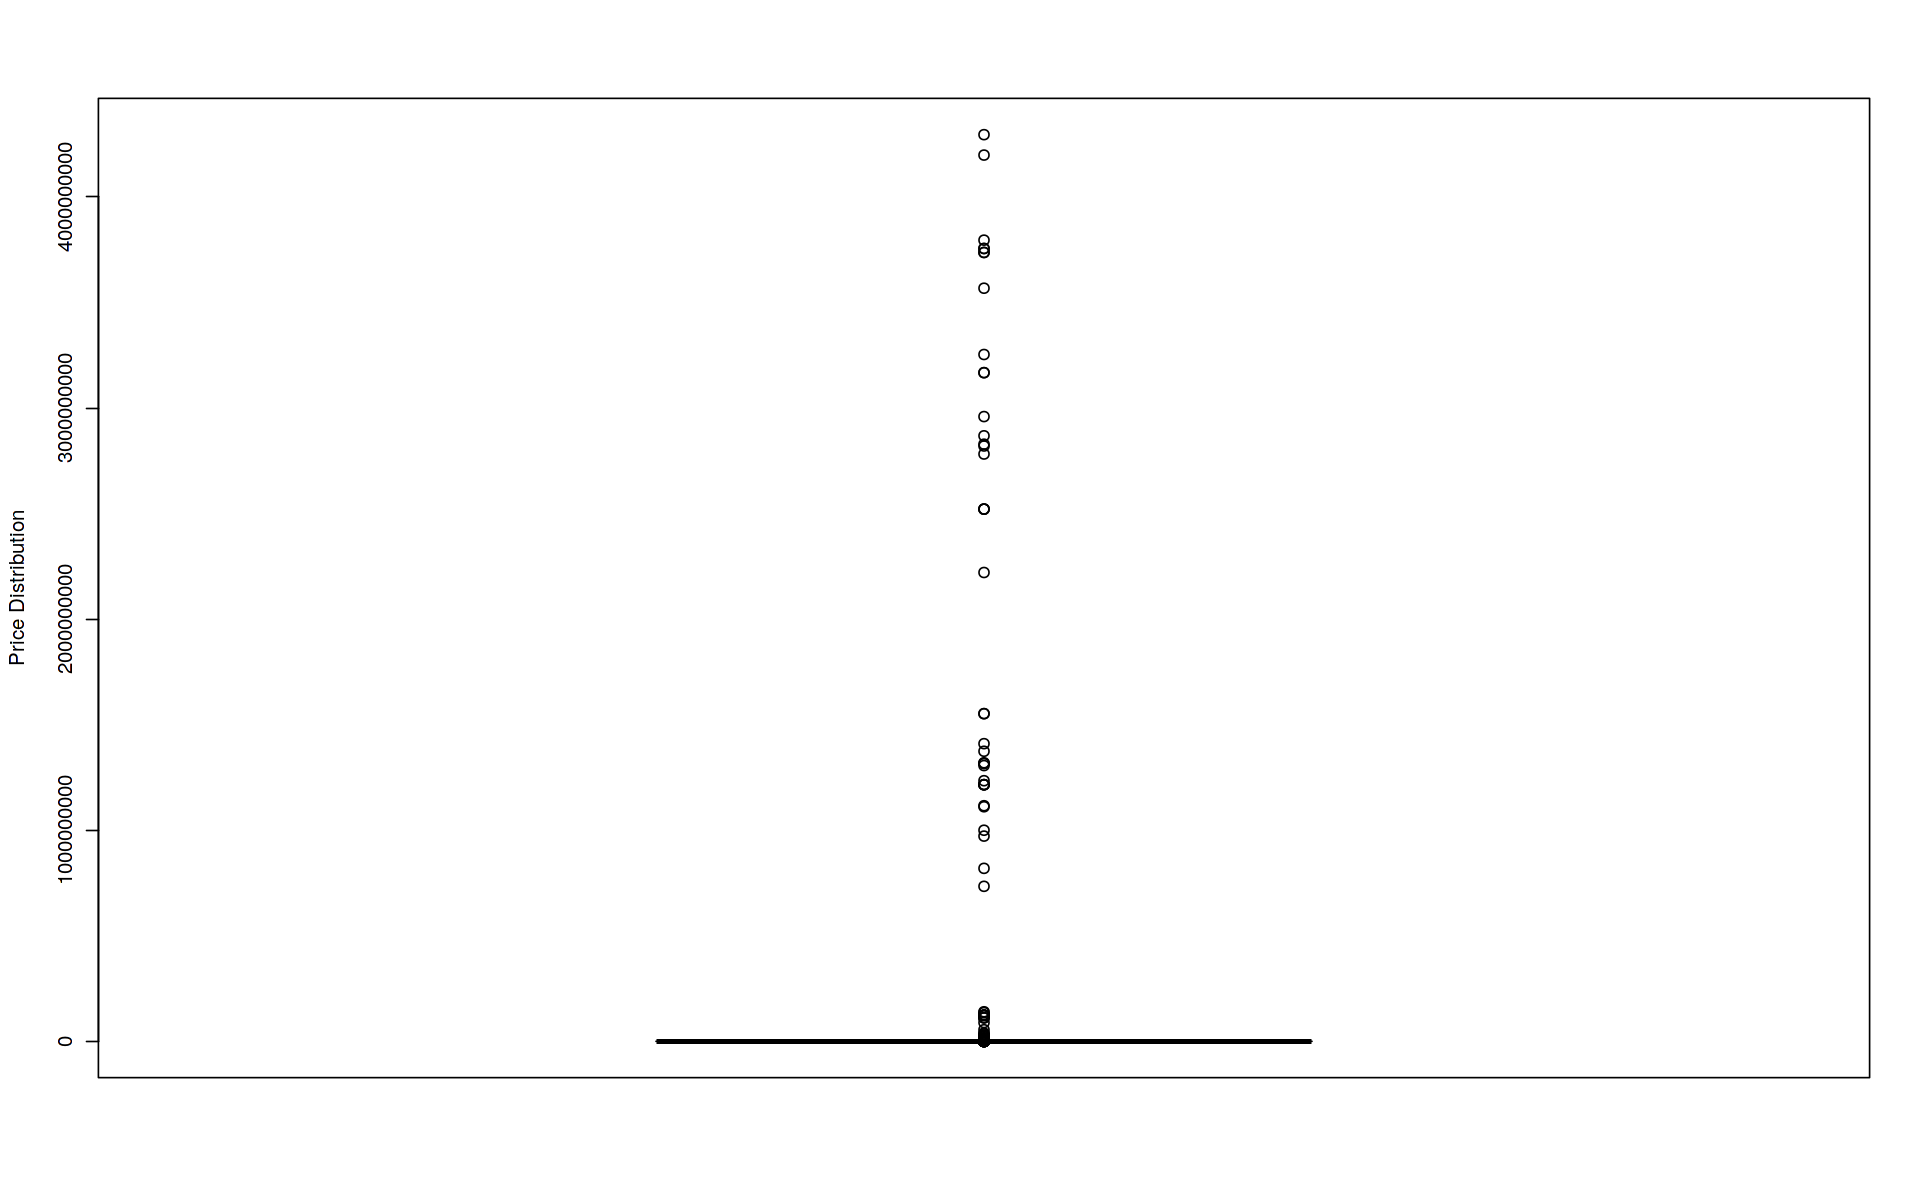

In [13]:
summary(df$price)
boxplot(df$price, ylab = 'Price Distribution')

We can see some absurd values in the `price` column. These values usually skew the data and pull the mean much higher than it actually would be. We will have to remove the outliers. Since this is a used cars dataset, the prices being so high are unlikely.<br>
Let us analyze these outliers on a granular level.

In [14]:
df[df$price > 500000,]

price      year manufacturer  fuel   odometer title_status transmission
27       14980499 2013 ford          gas     80683   clean        automatic   
1200   1316134911 2014 gmc           gas        NA   clean        automatic   
20231  1234567890 2005 chevrolet     gas    242099   salvage      automatic   
28098    24500499 2015 toyota        gas    103054   clean        automatic   
28954     1111111 2012 toyota        gas        NA   clean        automatic   
33088   113297506 2017 NA            gas        NA   clean        automatic   
35808    10000000 2003 honda         gas        NA   missing      automatic   
36350  2820142816 1967 NA            gas        NA   clean        automatic   
55358   972216506 2007 dodge         gas        NA   salvage      automatic   
59262  1215752191 1961 chevrolet     other      NA   clean        other       
61757  1215752191 1947 ford          other      NA   clean        other       
62929  1215752191 1957 chevrolet     other      NA   clean        other       
71813      900000 2018 chevrolet     diesel     NA   clean        automatic   
72302   123456789 1955 chevrolet     gas        NA   clean        manual      
75276  2521176519 2001 ford          gas        NA   clean        automatic   
92813     1200000 2007 NA            gas     30400   clean        automatic   
96515      595000 2020 NA            gas        NA   clean        automatic   
100874     678910 1955 NA            gas        NA   clean        manual      
111644    2500000 1947 NA            gas         0   clean        manual      
113376 1111222223 2007 cadillac      gas        NA   salvage      automatic   
118111 3755744318 2005 ford          gas    154000   clean        automatic   
121300   11111111 2008 ford          gas        NA   clean        automatic   
127568     600000 2006 mercedes-benz gas    126500   clean        automatic   
128373 1116080943 2012 honda         gas     98090   clean        automatic   
128374  819412050 2015 nissan        gas     87397   clean        automatic   
128375 2959541855 2010 mazda         gas    116804   clean        manual      
128376 2868355711 2010 toyota        gas    126499   clean        automatic   
128524     629000 2008 gmc           gas     99251   clean        automatic   
130907  123456789 2010 cadillac      gas    132321   clean        automatic   
132011  123456789 1995 ford          gas    148284   clean        automatic   
⋮      ⋮          ⋮    ⋮             ⋮      ⋮        ⋮            ⋮           
264446     999500 2013 toyota        gas    129000   clean        automatic   
272776  123456789 1950 chevrolet     gas        NA   clean        automatic   
275628  123456789 2005 jeep          gas        NA   clean        other       
279599 2521176519 1972 dodge         gas     53000   clean        automatic   
288853   35006500 2012 chevrolet     gas        NA   clean        automatic   
290505   88888888 2008 nissan        gas        NA   clean        automatic   
294472   25006500 2012 chevrolet     gas        NA   clean        automatic   
302823   11111111 1965 ford          gas        NA   clean        automatic   
304242   39000000 1932 ford          gas        NA   clean        automatic   
305590    1500000 2004 infiniti      gas    190000   clean        automatic   
306062 3795255043 2005 lexus         gas    133669   clean        automatic   
306064 3167547323 2014 toyota        gas    147107   clean        automatic   
311018    1111111 1983 mercedes-benz diesel 125000   clean        manual      
317497   22222222 1927 ford          gas        NA   clean        automatic   
319904   17000000 2004 ford          gas        NA   lien         automatic   
320618 2521065408 2007 cadillac      gas        NA   salvage      automatic   
321083    2650000 1991 NA            diesel     NA   clean        other       
325669 2220913095 1984 NA            diesel     NA   clean        automatic   
331404  123456789 1994 NA            gas    142374   clea

As a first step, let us remove data where the prices are more than 500000. Prices above this seem too high and could be erroneous. We will look at the distribution of the data again using a boxplot. Since the absurd very high prices are removed, we should now be able to see a better distribution.

In [15]:
df = filter(df,df$price <= 500000)
head(df,5)

price year manufacturer fuel odometer title_status transmission drive
1 10299 2012 acura        gas   90186   clean        automatic    NA   
2     0 2011 bmw          gas  115120   clean        automatic    rwd  
3  9500 2011 jaguar       gas   85000   clean        automatic    NA   
4  3995 2004 honda        gas  212526   clean        automatic    fwd  
5 41988 2016 chevrolet    gas      NA   clean        automatic    NA   
  type        lat     long    
1 other       35.7636 -78.7443
2 convertible      NA       NA
3 NA          36.1032 -79.8794
4 SUV         35.7636 -78.7443
5 NA          41.1345 -96.2458

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    4300    8995   12059   16900  479000 

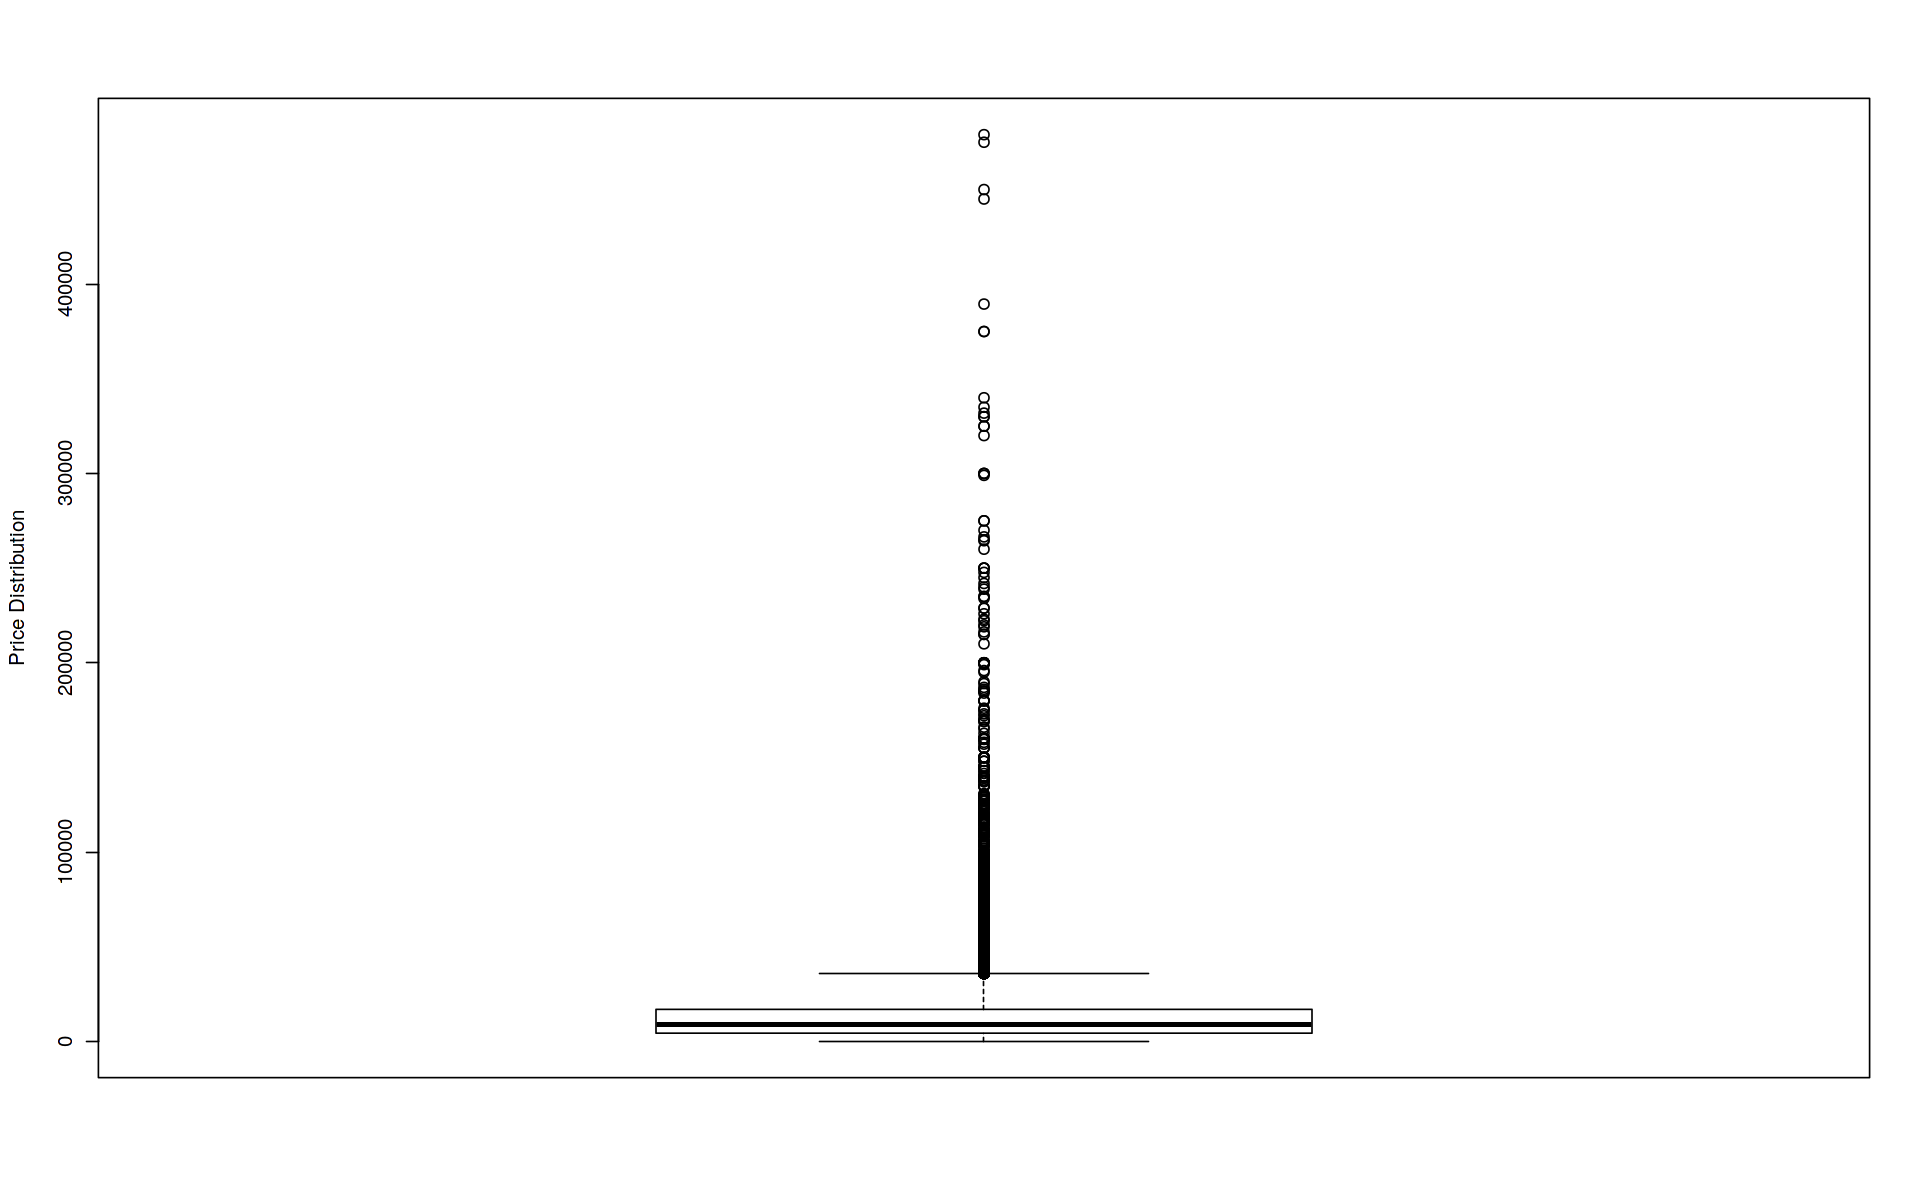

In [16]:
summary(df$price)
boxplot(df$price, ylab = 'Price Distribution')

The box plot shows there are still many outliers.
To further rectify this, we will set up a threshold using the `interquartile range` (IQR). Instead of deciding on a threshold myself, this method can easily give me a bound that would be reasonable with respect to the data in general.<br>
interquartile range = 75% - 25%<br>

The dataset used is very large and is bound to have many outliers. The `interquartile range` (IQR) method automatically fits the distribution to normal form and remove the outliers. It does remove the data points very generously and we could be losing valuable information.<br>

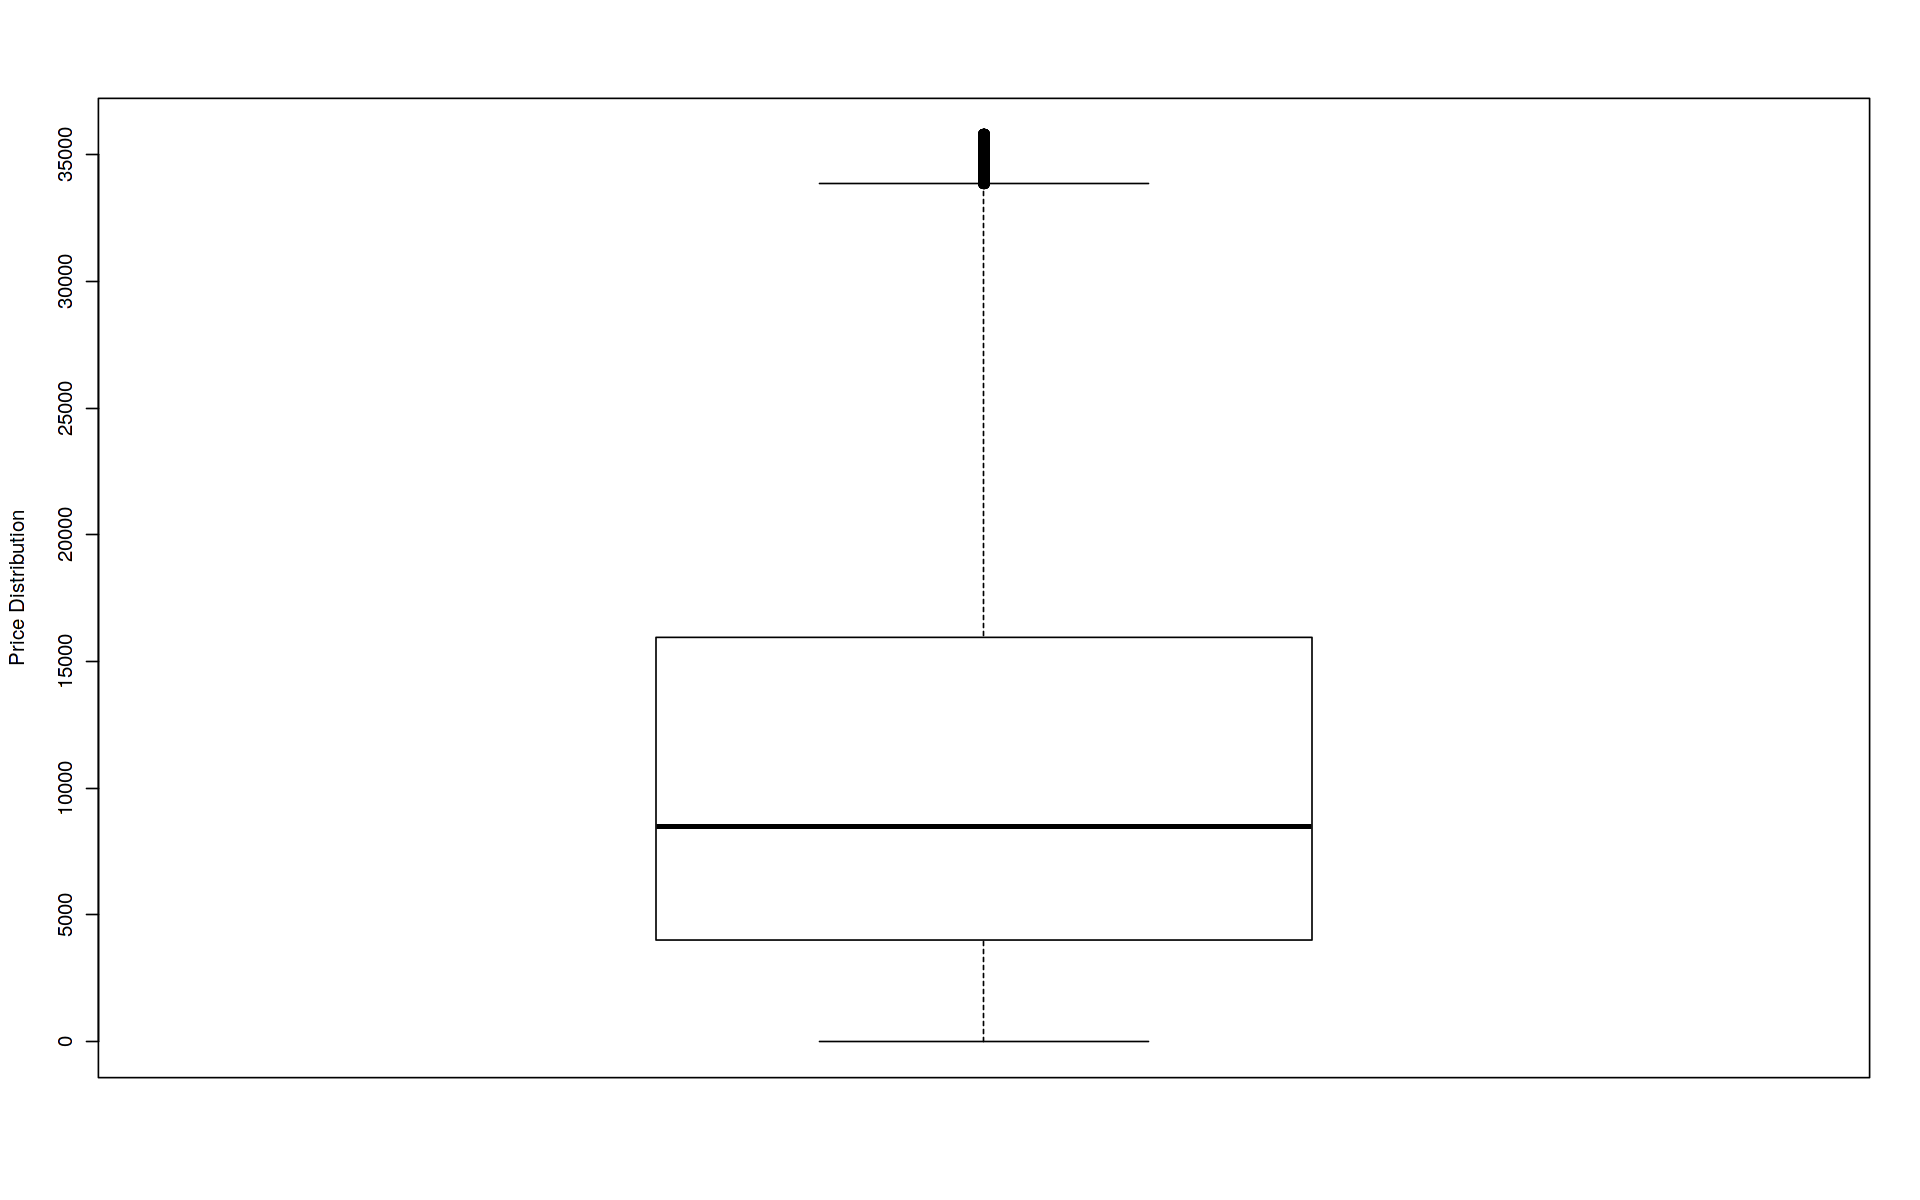

In [17]:
stats = summary(df$price)
interquartile = stats[5] - stats[2]
thresh = interquartile * 1.5
upper = stats[5] + thresh
lower = stats[2] - thresh

df = filter(df,between(df$price,lower,upper))
boxplot(df$price, ylab='Price Distribution')

Apart from the price, the derived dataset only contains two numerical columns, the odometer and the year. We will analyze these values to identify how they influence the price.

In [18]:
summary(df[c('odometer','year')])

    odometer             year     
 Min.   :       0   Min.   :   0  
 1st Qu.:   50219   1st Qu.:2006  
 Median :   96697   Median :2011  
 Mean   :  104519   Mean   :2009  
 3rd Qu.:  141153   3rd Qu.:2015  
 Max.   :64809218   Max.   :2021  
 NA's   :73181      NA's   :399   

The year column seems unrealistic at 2021. Let us plot a countplot for the year to see the trend in buying/selling used cars on craigslist. We can tell that sales actually began increasing after 1990. Hence we will consider data after this point in time as years below that wud have less representative data.

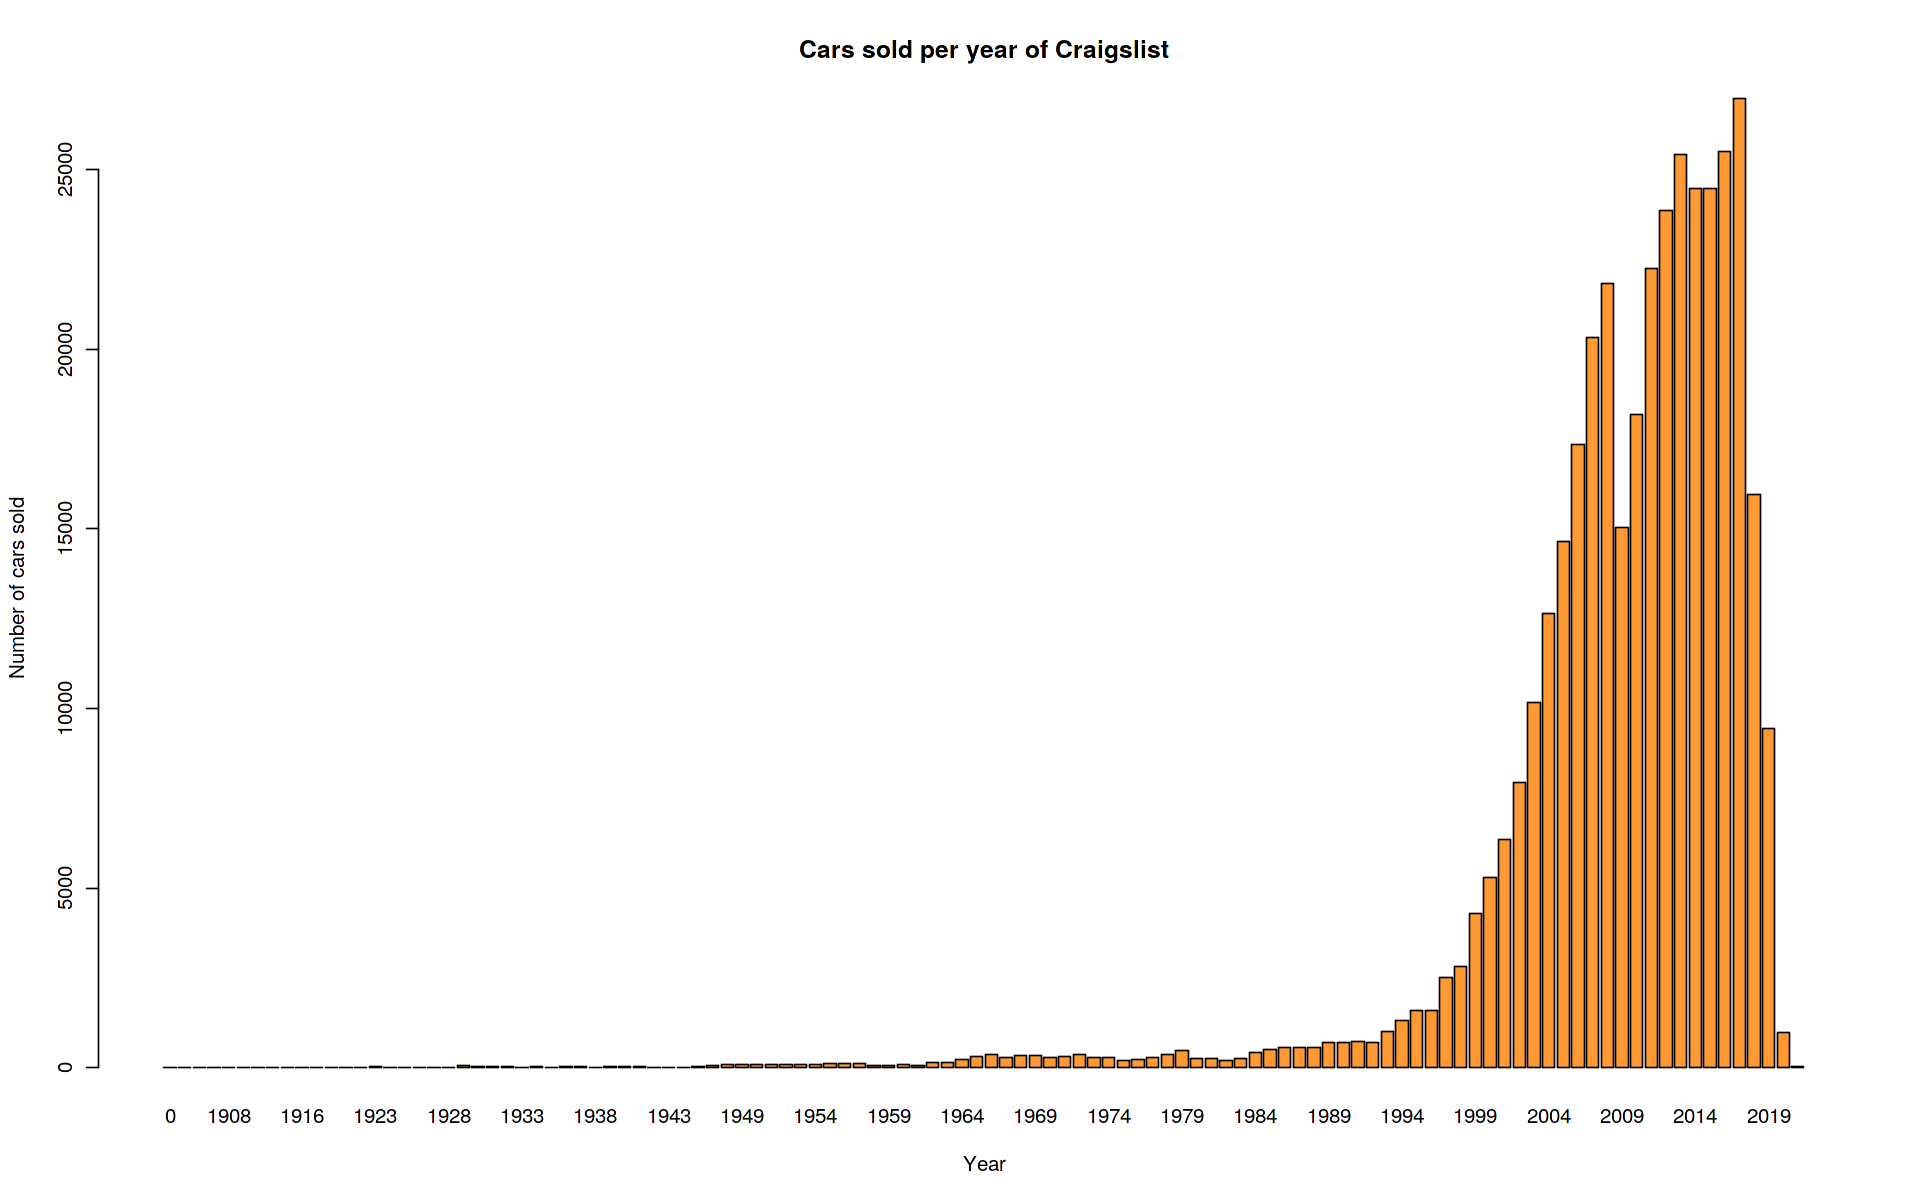

In [19]:
tbl = table(df$year)
barplot(tbl,
        xlab = 'Year',
        ylab = 'Number of cars sold',
        main = "Cars sold per year of Craigslist",
        col = '#ff9933'
       )

Our assumption was right, only after 1990, there are significant data points for car being sold. So we will limit out year column to 1990 and 2020.

In [20]:
# df[between(df$year,1960,2020),]
df = filter(df,between(df$year,1985,2020))

The important thing to analyze is whether there exists a relationship between year and price.

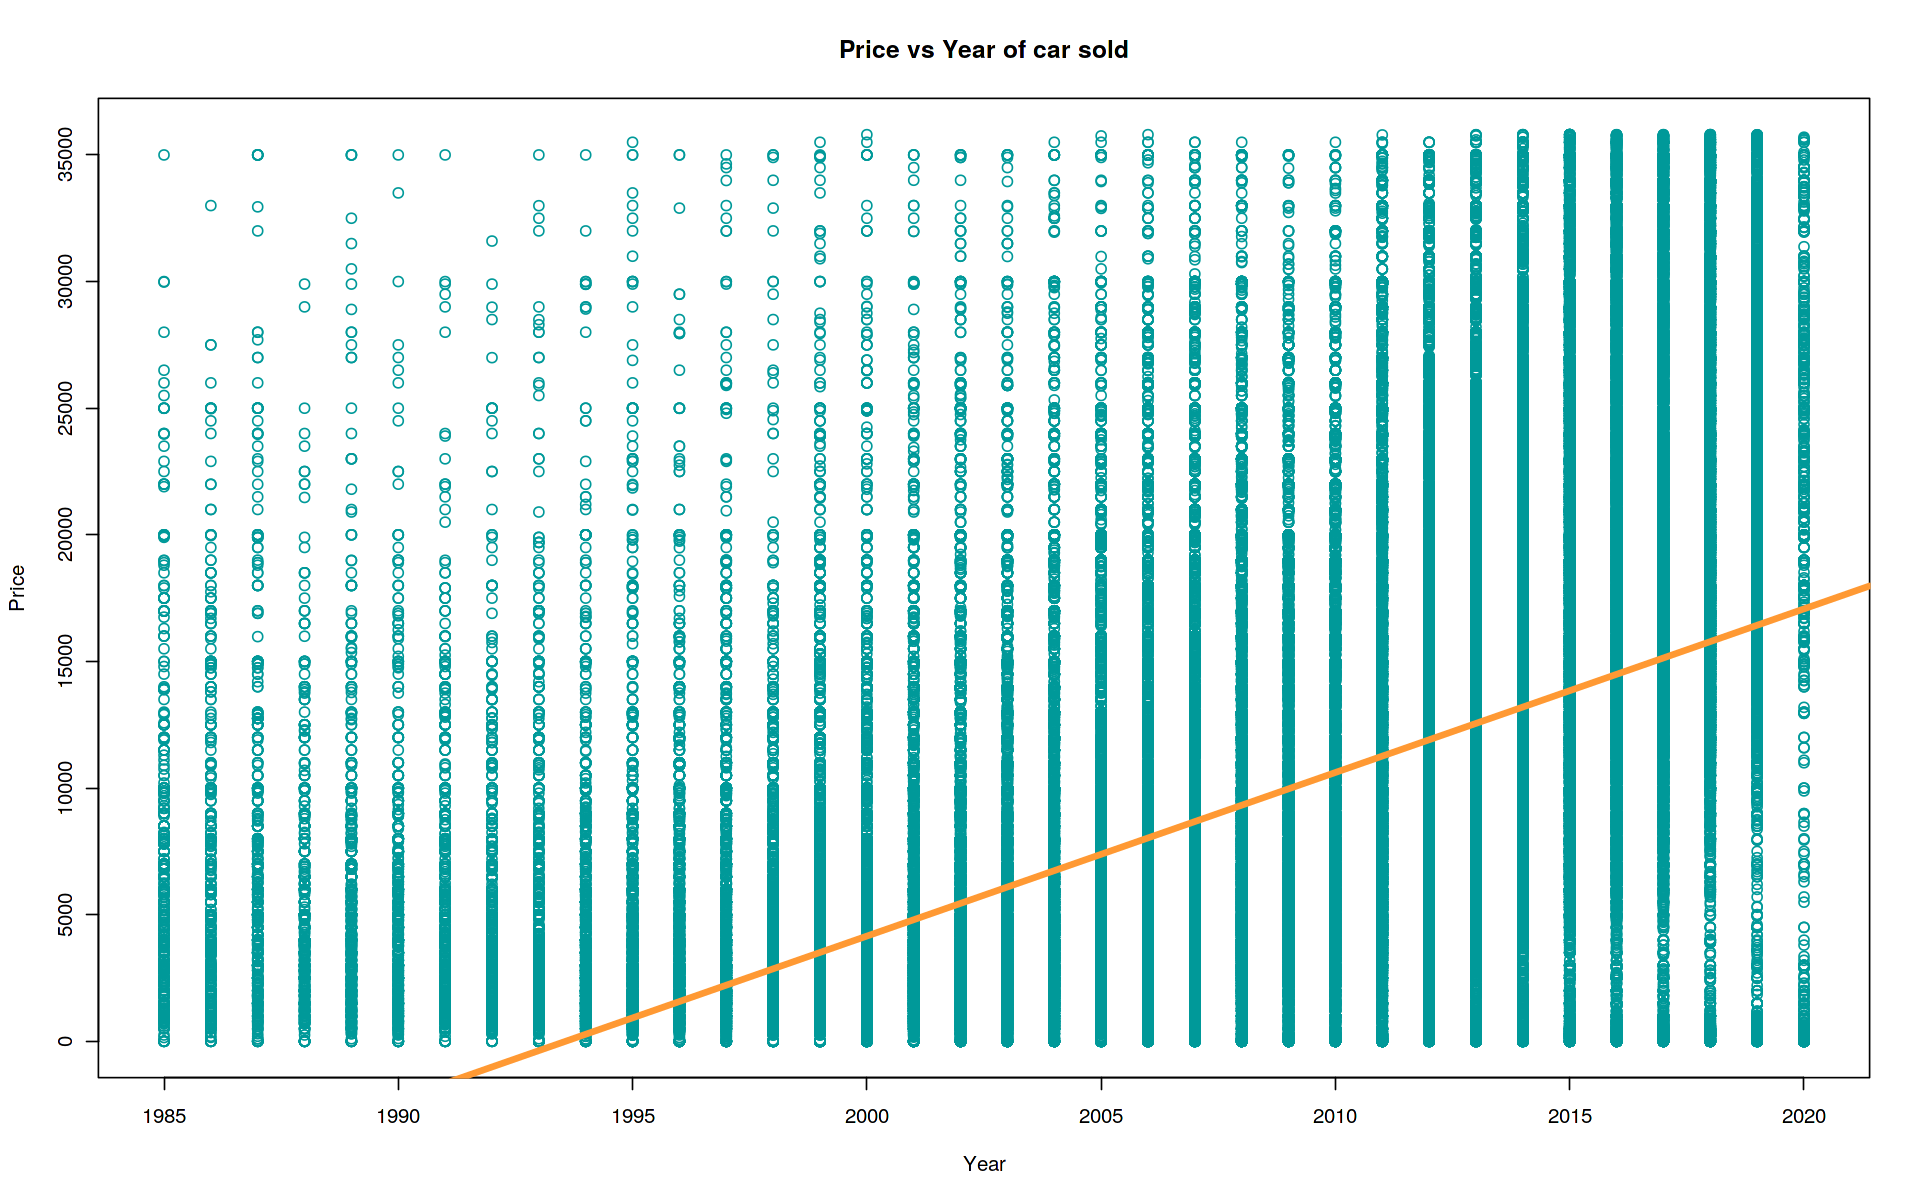

In [21]:
plot(
    df$year,
    df$price,
    xlab = 'Year',
    ylab = 'Price',
    main = 'Price vs Year of car sold',
    col = '#009999'
)
abline(lm(price ~ year, data = df), col='#ff9933', lwd=4)

The plot shows a positive correlation between the year and price. Even though these exists some Linear correlation, prices from every year have a wide range and the increase in prices over the years is not continuous. Another issue is that the number of cars sold over the years varies drastically, this can cause the mean to shift. As shown in the plot below.

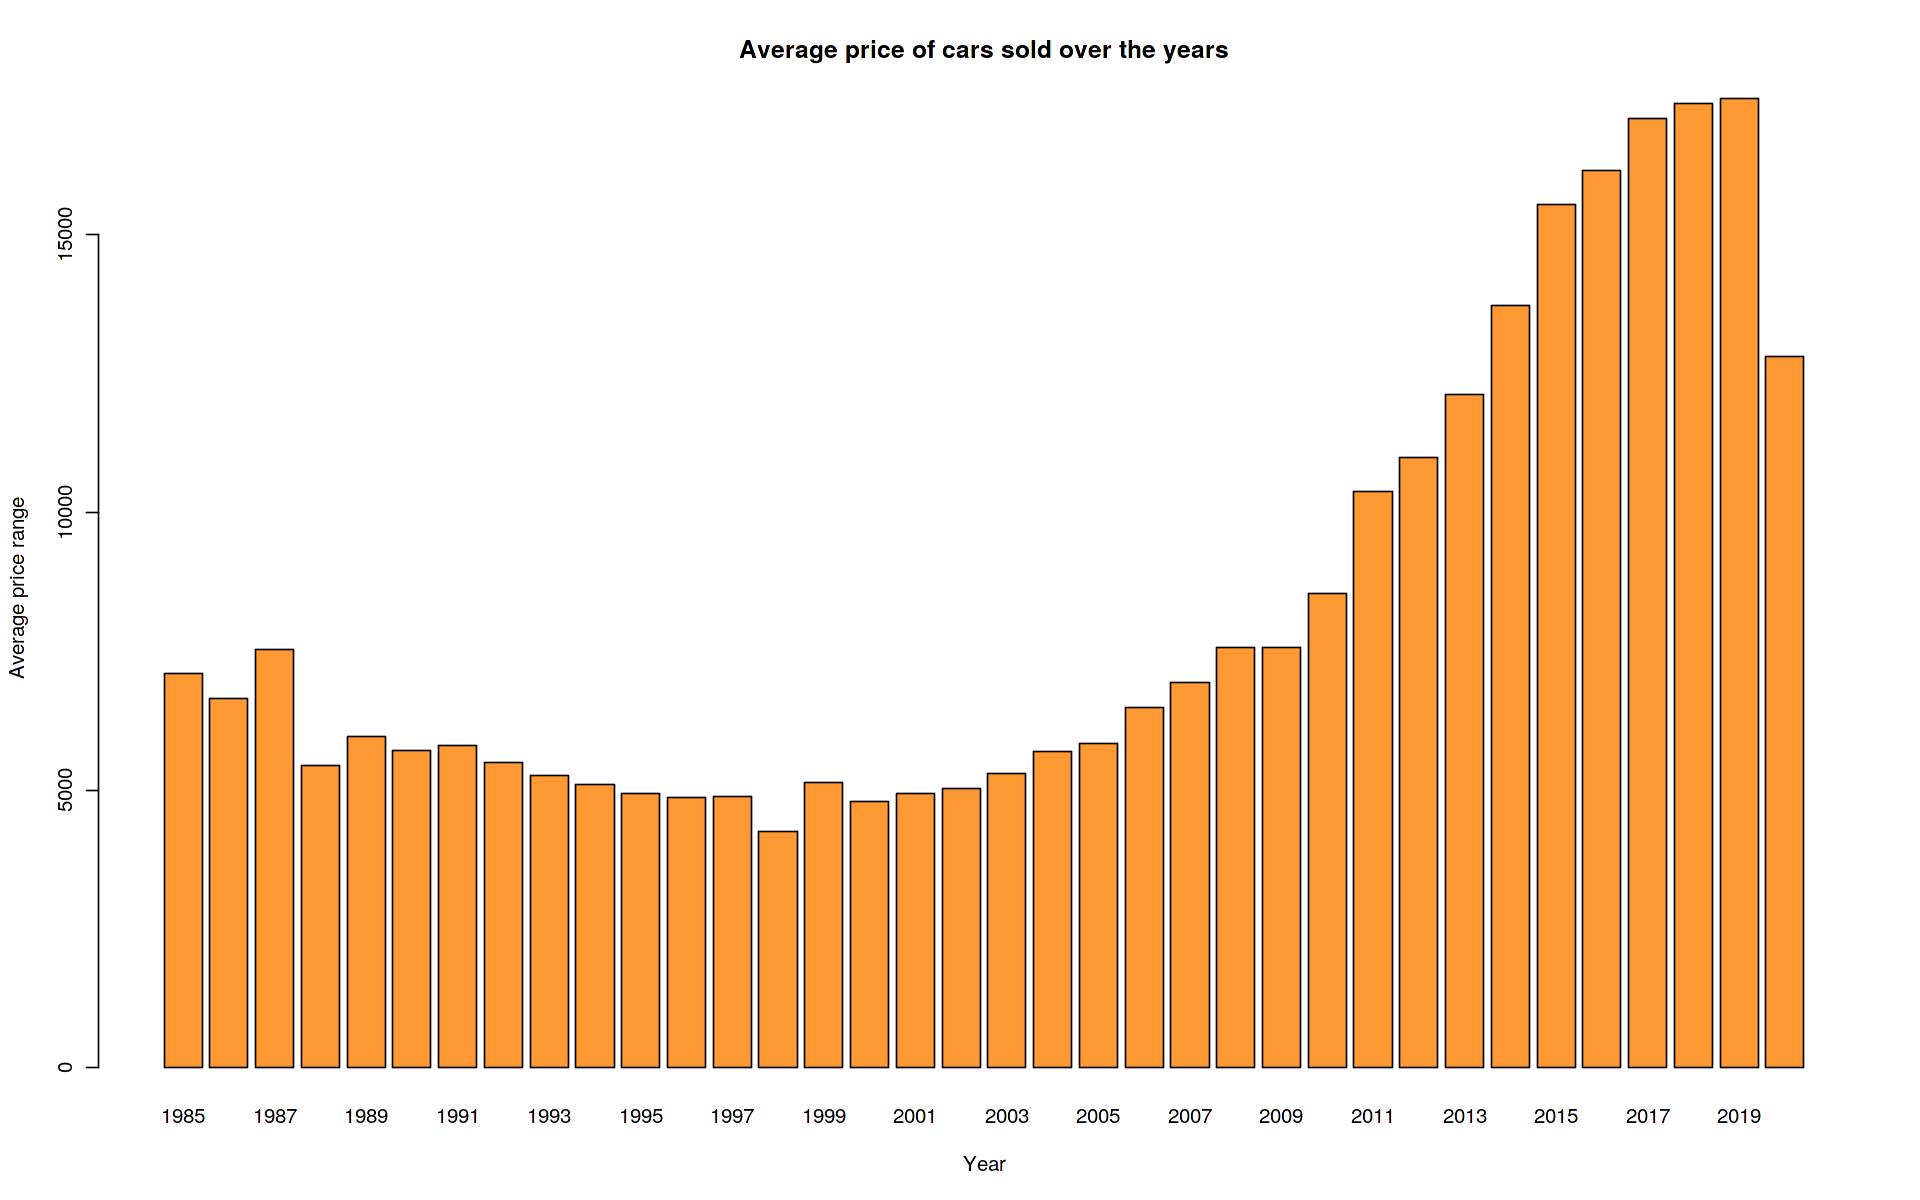

In [22]:
grouped = df %>% group_by(year) %>% summarise(avg_price = mean(price))

barplot(
    names.arg = grouped$year,
    height =  grouped$avg_price,
    xlab = 'Year',
    ylab = 'Average price range',
    main = 'Average price of cars sold over the years',
    col = '#ff9933'
)

Intuituvely the affect of year on the price is limited to changes in markets and economies leading to price shifts in the entire industry. The plot shows this shift, where vehicles in years between 1985 and 2005 seemed to have lesser prices in general, then the industry shot up from 2006 onwards. As assumed before, the plot confirms it.<br>
The year column can be considered for the model given its positive correlation.

The odometer column describes the distance the vehicle has already travelled. This is an important factor for a buyer. From the previous `summary()` function run, odometer also has some very absurd values. These values are too high as most cars usually have a limit to how many miles it can travel before an engine replacement is required.

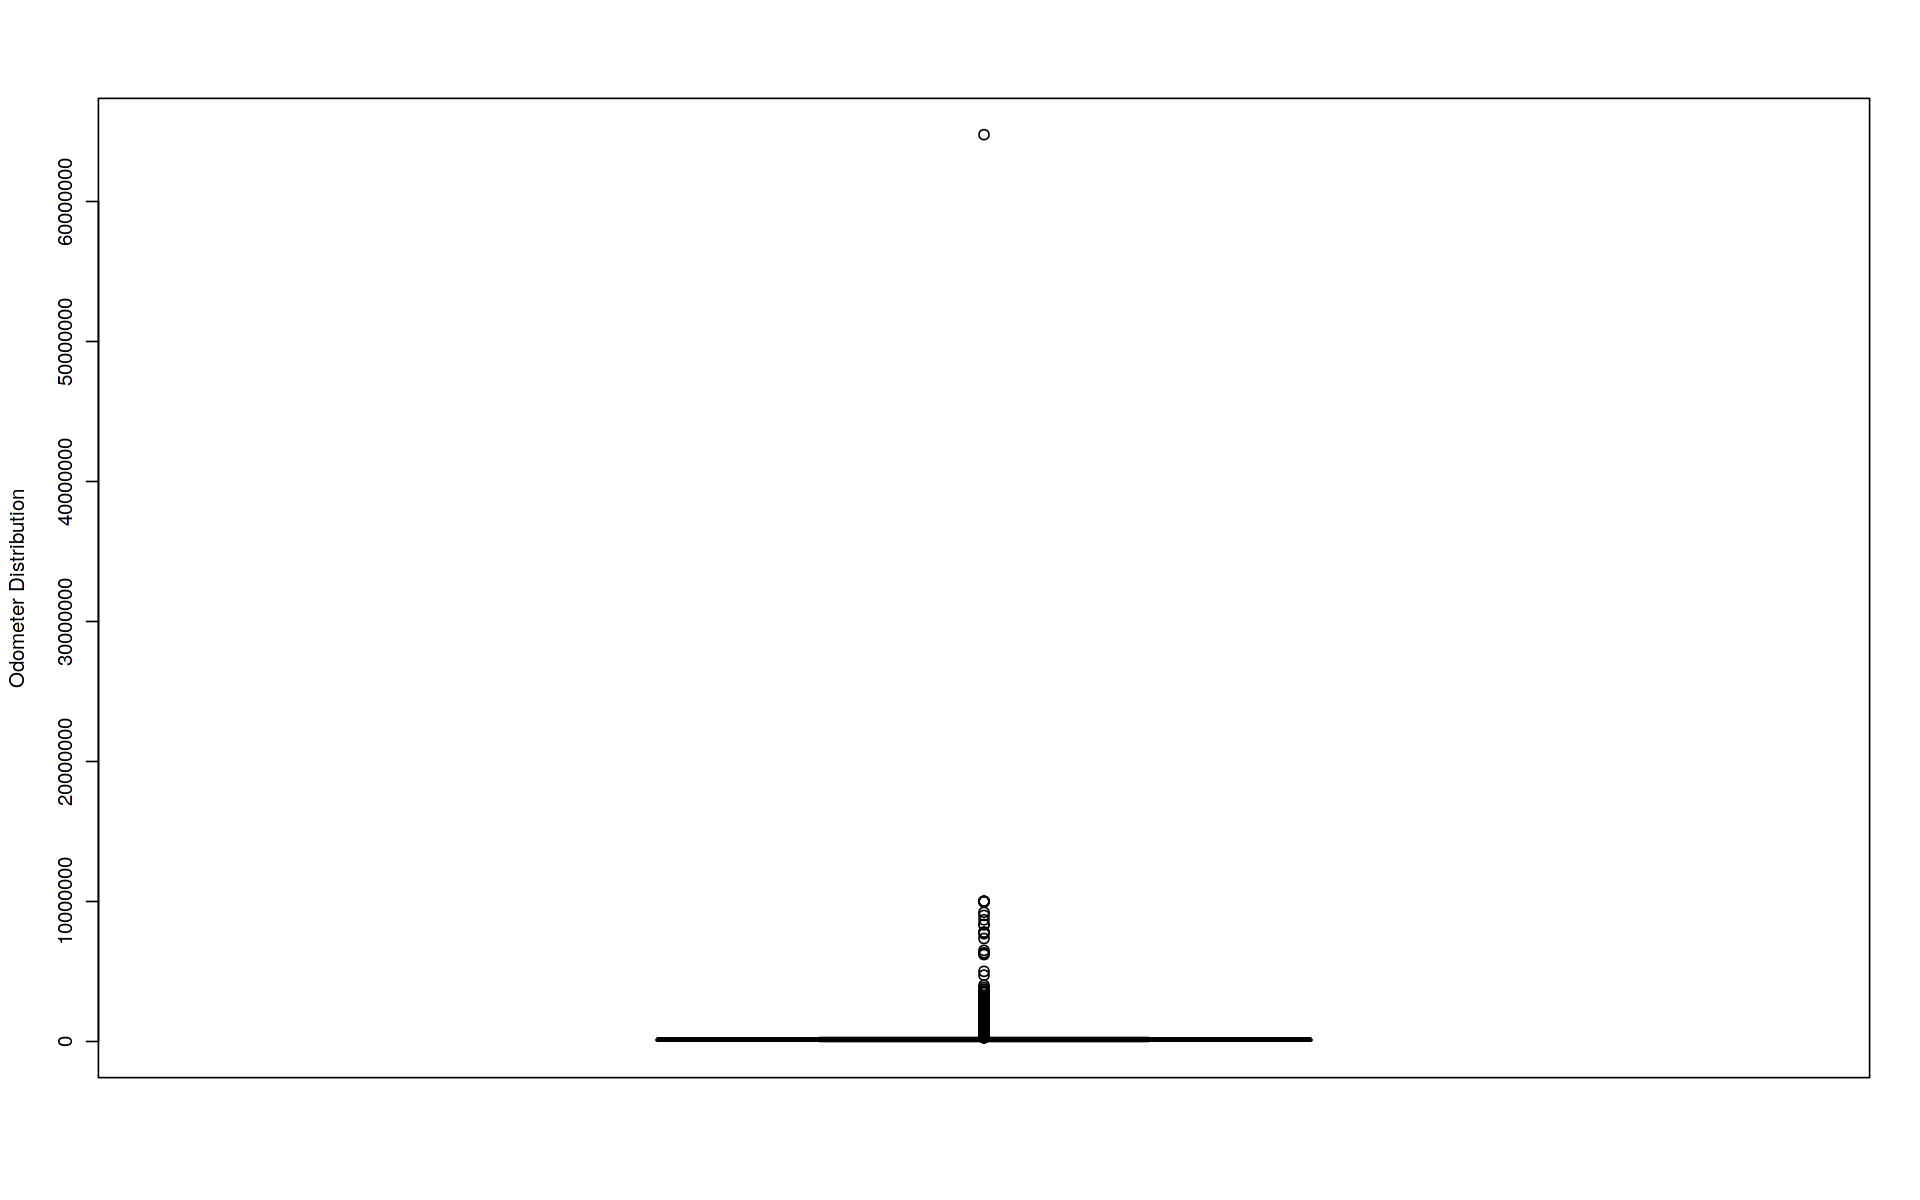

In [23]:
boxplot(df$odometer, ylab = 'Odometer Distribution')

Analyzing more granular information, i.e. odometer values that are above 150000.<br>
The threshold is chosen arbitarily. 

In [24]:
filter(df,df$odometer > 1500000)

price year manufacturer fuel   odometer title_status transmission drive
1    2700 2003 honda        gas    2170000  clean        automatic    fwd  
2    2000 2003 subaru       gas    2000000  clean        automatic    4wd  
3    2200 2004 toyota       hybrid 2999999  clean        automatic    fwd  
4     900 2004 nissan       gas    2110000  clean        automatic    4wd  
5    7500 2000 ford         gas    8343040  clean        automatic    fwd  
6    4000 2008 ford         diesel 3500000  clean        automatic    rwd  
7    8895 2004 ford         gas    2079503  clean        automatic    4wd  
8    3200 2005 ford         diesel 2121575  clean        automatic    4wd  
9    4450 2000 toyota       gas    2727000  clean        automatic    rwd  
10   6500 2004 ford         gas    1623262  clean        automatic    fwd  
11   2500 2001 chevrolet    gas    2000000  clean        automatic    4wd  
12   5000 2019 chevrolet    gas    4728224  clean        automatic    NA   
13   6000 2002 ford         diesel 3000000  clean        automatic    4wd  
14  29800 2006 ford         diesel 1698750  clean        automatic    4wd  
15   6000 2007 lincoln      gas    1646500  clean        automatic    rwd  
16   7500 1999 ram          diesel 1901724  clean        automatic    4wd  
17  32500 2011 NA           diesel 3250000  clean        automatic    4wd  
18   5700 1999 chevrolet    gas    1900000  clean        automatic    4wd  
19   6875 2012 toyota       gas    1570000  clean        automatic    fwd  
20   3500 2006 toyota       hybrid 1987700  clean        automatic    NA   
21  33000 2001 NA           diesel 1581983  clean        manual       NA   
22  24500 2015 ford         gas    2590000  clean        automatic    4wd  
23   1200 2003 ford         gas    2740000  salvage      automatic    NA   
24  18700 2006 ram          diesel 2051670  clean        automatic    4wd  
25    500 1991 chevrolet    gas    2400000  clean        automatic    4wd  
26   2000 2005 honda        gas    1940000  clean        automatic    fwd  
27   5495 2008 chevrolet    gas    1600000  clean        automatic    4wd  
28    650 2000 NA           gas    1666802  clean        automatic    4wd  
29  19000 2012 NA           diesel 7788852  clean        manual       NA   
30   7000 2003 chevrolet    diesel 2490000  clean        automatic    4wd  
⋮   ⋮     ⋮    ⋮            ⋮      ⋮        ⋮            ⋮            ⋮    
163  3500 2004 toyota       gas     2771110 clean        automatic    NA   
164 10500 1990 NA           diesel  9999999 clean        manual       rwd  
165     0 2020 NA           gas     9220158 clean        automatic    NA   
166  3200 2004 toyota       gas     2100000 clean        automatic    NA   
167  3899 2004 chevrolet    gas     1940000 clean        automatic    4wd  
168  2995 2001 ford         gas     9999999 clean        automatic    rwd  
169  2700 2001 lexus        gas     2980000 salvage      automatic    rwd  
170  4000 2011 mazda        gas     1700400 clean        automatic    fwd  
171  3950 2001 lexus        gas     1970000 clean        automatic    fwd  
172  2800 2004 acura        gas     1710000 rebuilt      automatic    4wd  
173  2000 2005 chevrolet    gas     2000000 clean        automatic    NA   
174  6995 2006 lexus        gas     2182111 clean        automatic    NA   
175  3900 2009 gmc          gas     1950000 clean        automatic    NA   
176  3500 1998 nissan       diesel  2007000 clean        other        rwd  
177  5500 2001 ford         diesel  2580000 clean        automatic    4wd  
178  7900 2008 audi         gas    64809218 NA           automatic    4wd  
179 15500 2012 infiniti     gas     3840000 clean        automatic    rwd  
180  1500 1999 dodge        gas     1999999 clean        automatic    rwd  
181 32000 2015 gmc          gas     6500000 clean        automatic    fwd  
182  2500 2004 pontiac      gas     1990000 salvage      automatic    NA   
183  7500 2009 honda        gas     1553535 clean   

The odometer values above 1000000 are too high and seem unreasonable. The model should be realistic and not dependent completely on data. Hence we will remove the rows with odometer values greater than 1000000.

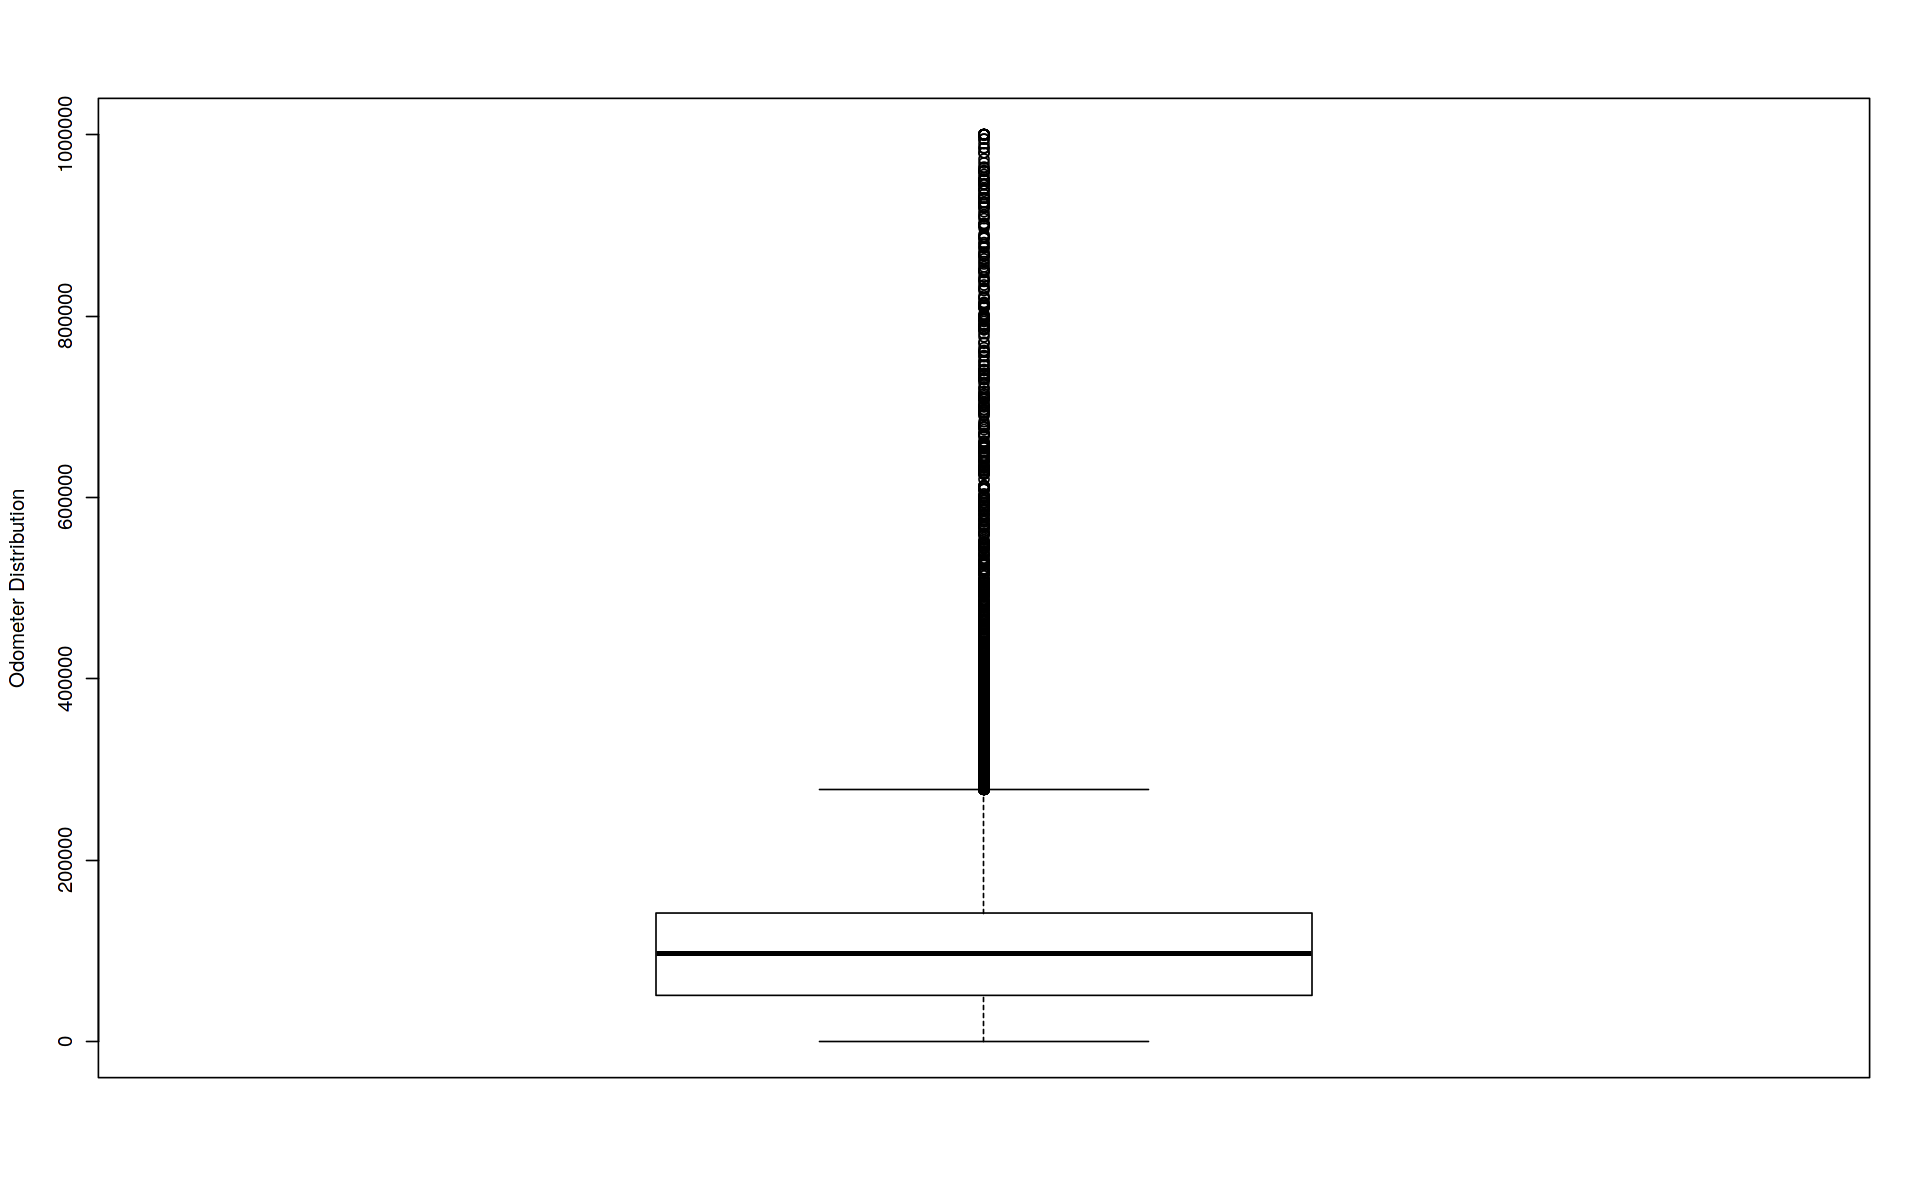

In [25]:
df = filter(df, df$odometer <= 1000000)

boxplot(df$odometer, ylab = 'Odometer Distribution')

There still exists many outliers. Thus the same `interquartile range` (IQR) method is applied here.

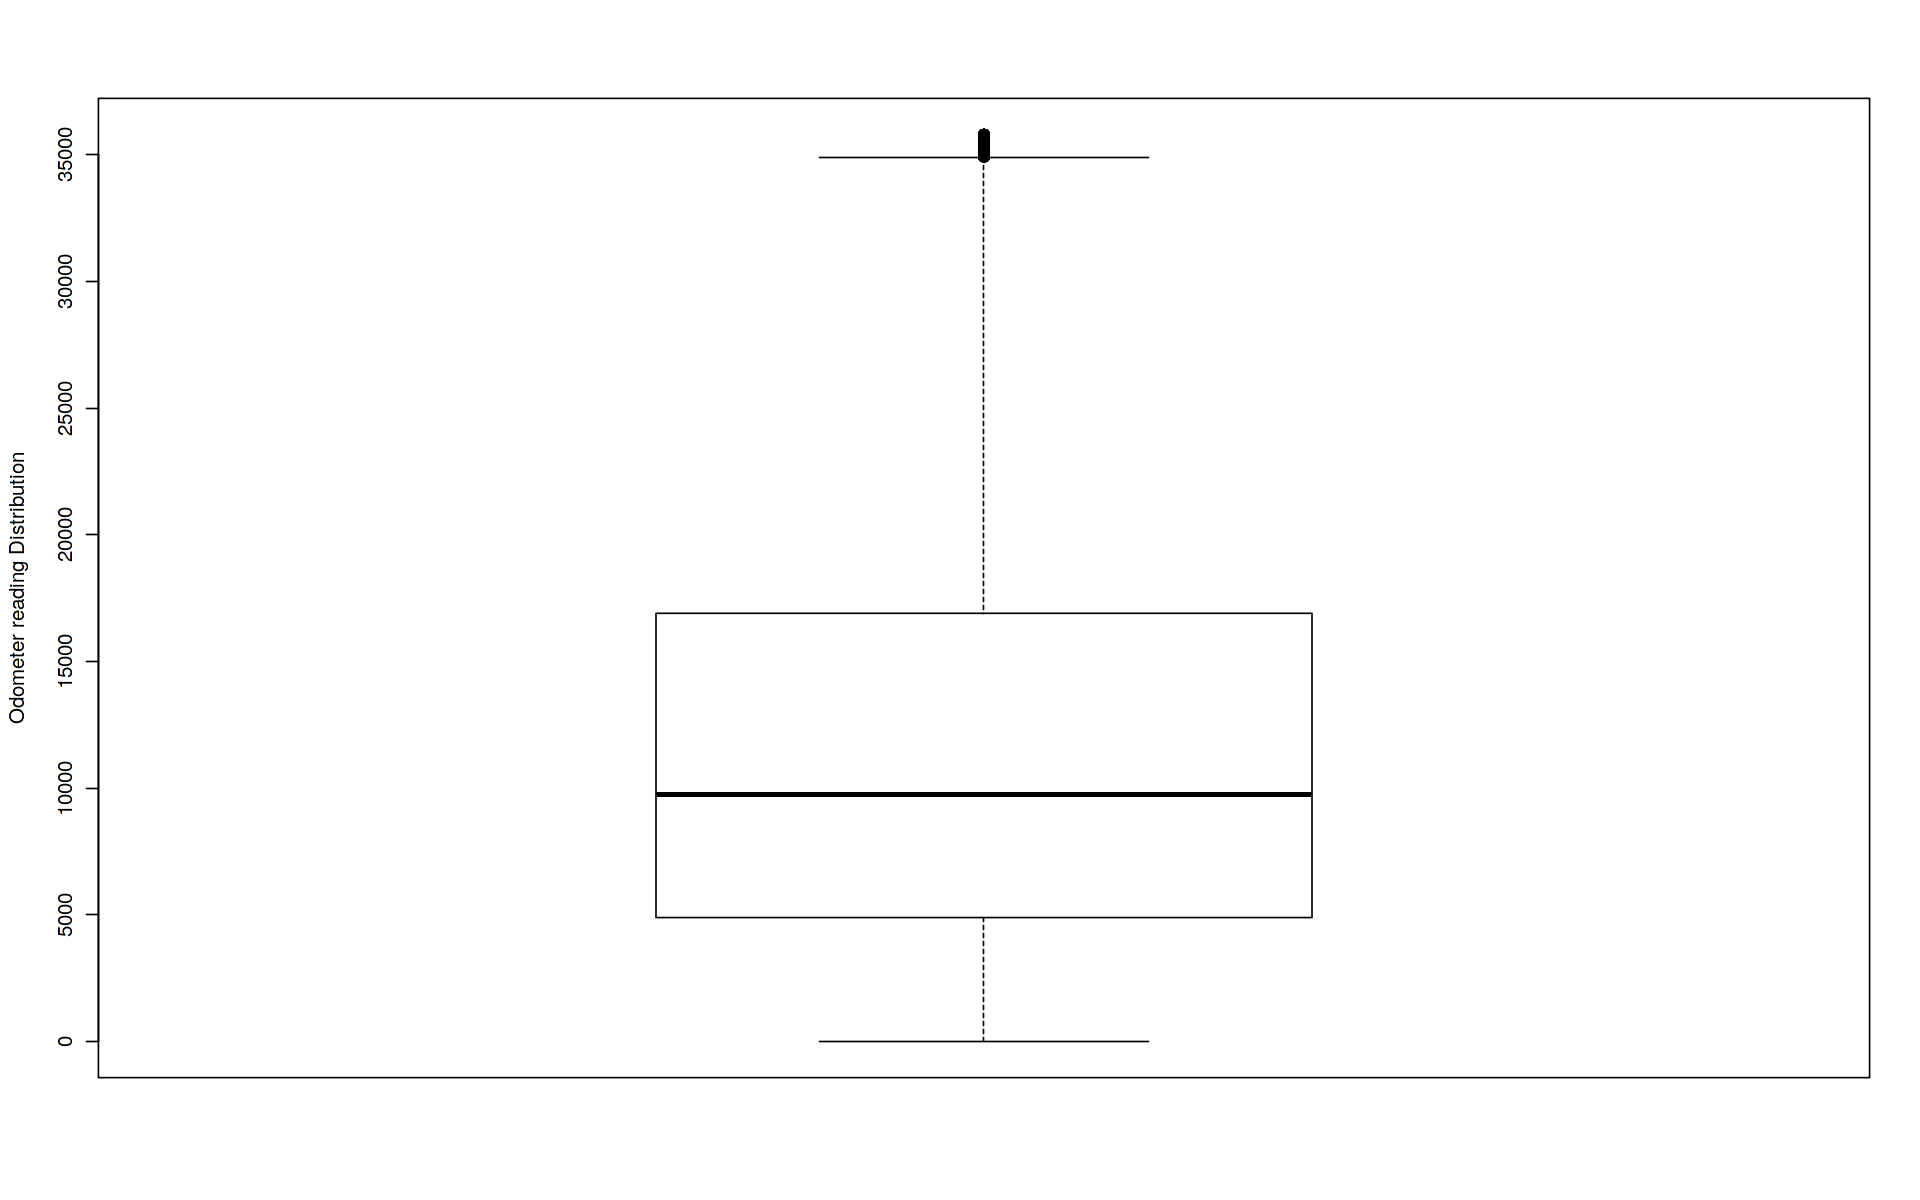

In [26]:
stats = summary(df$odometer)
interquartile = stats[5] - stats[2]
thresh = interquartile * 1.5
upper = stats[5] + thresh
lower = stats[2] - thresh

df = filter(df,between(df$odometer,lower,upper))
boxplot(df$price, ylab='Odometer reading Distribution')

We have achieved a good spread now, and that will be enough for now. Let us analyze the relationship between odometer and the price of the car.

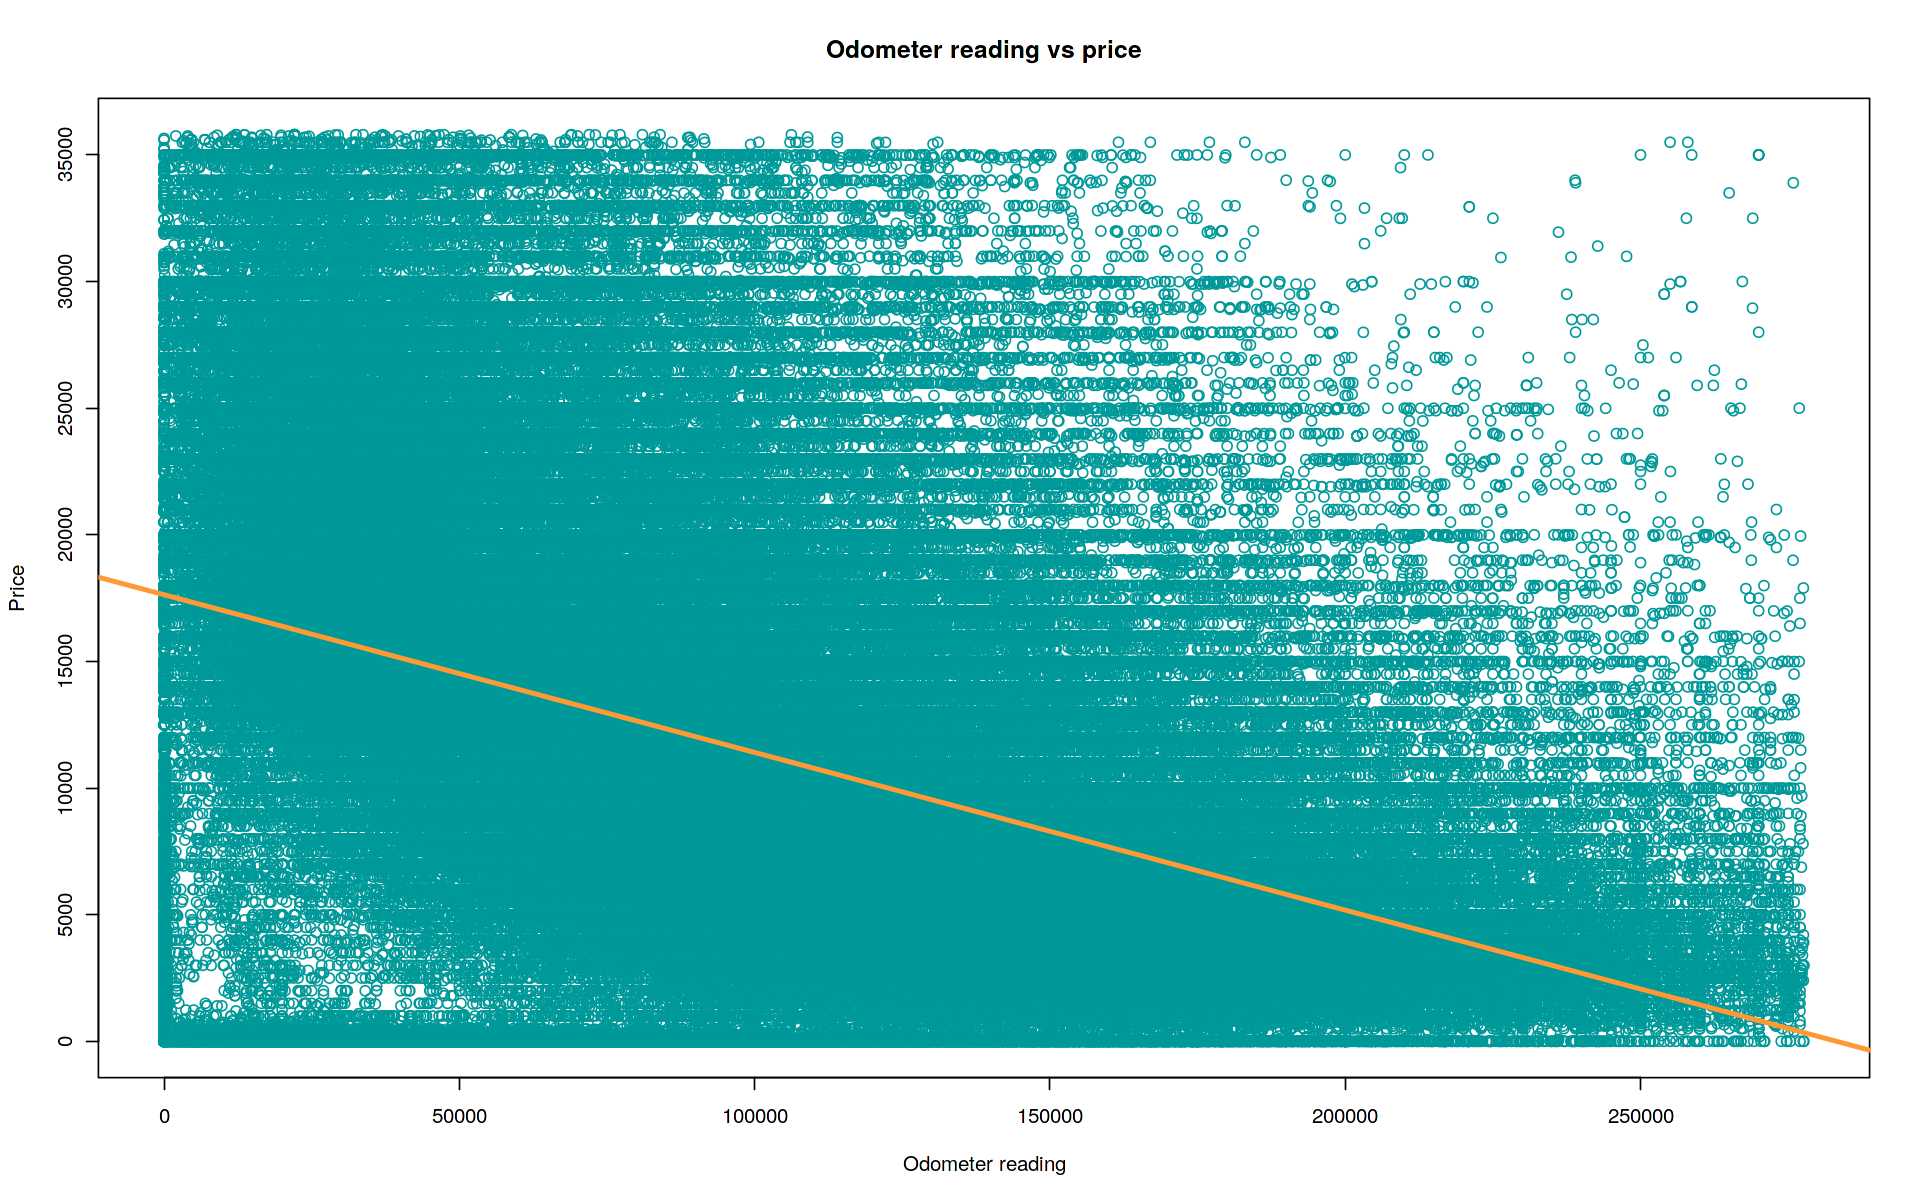

In [27]:
plot(
    df$odometer,
    df$price,
    xlab = 'Odometer reading',
    ylab = 'Price',
    main = 'Odometer reading vs price',
    col = '#009999'
)
abline(lm(price~odometer,data=df),col='#ff9933', lwd=3)

The odometer vs price plot draws the following conclusions:

* The regression line shows negative correlation
* As the odometer reading increases, the price of the car decreases (not entirely)

Let us now look at the nominal or ordinal variables that we have. Lets understand the manufacturer and type columns. The analysis on the data is to show vehicles of which manufacturers and type of vehicles are selling most online.<br>

We find the Top 10 manufacturers listed on craigslist based on two criteria.
* Manufacturers with most sold cars.
* Manufacturers with highest prices.

In [28]:
grouped = as.data.frame(df %>% group_by(manufacturer) %>% summarise(avg_price = mean(price)))
top_sold = head(grouped[order(- grouped$avg_price),],9)
top_sold

manufacturer avg_price
37 tesla        22380.25 
2  alfa-romeo   19348.85 
33 ram          16847.51 
34 rover        14522.15 
3  aston-martin 14244.25 
14 gmc          14052.63 
32 porche       13783.22 
20 jeep         13457.74 
4  audi         12985.45

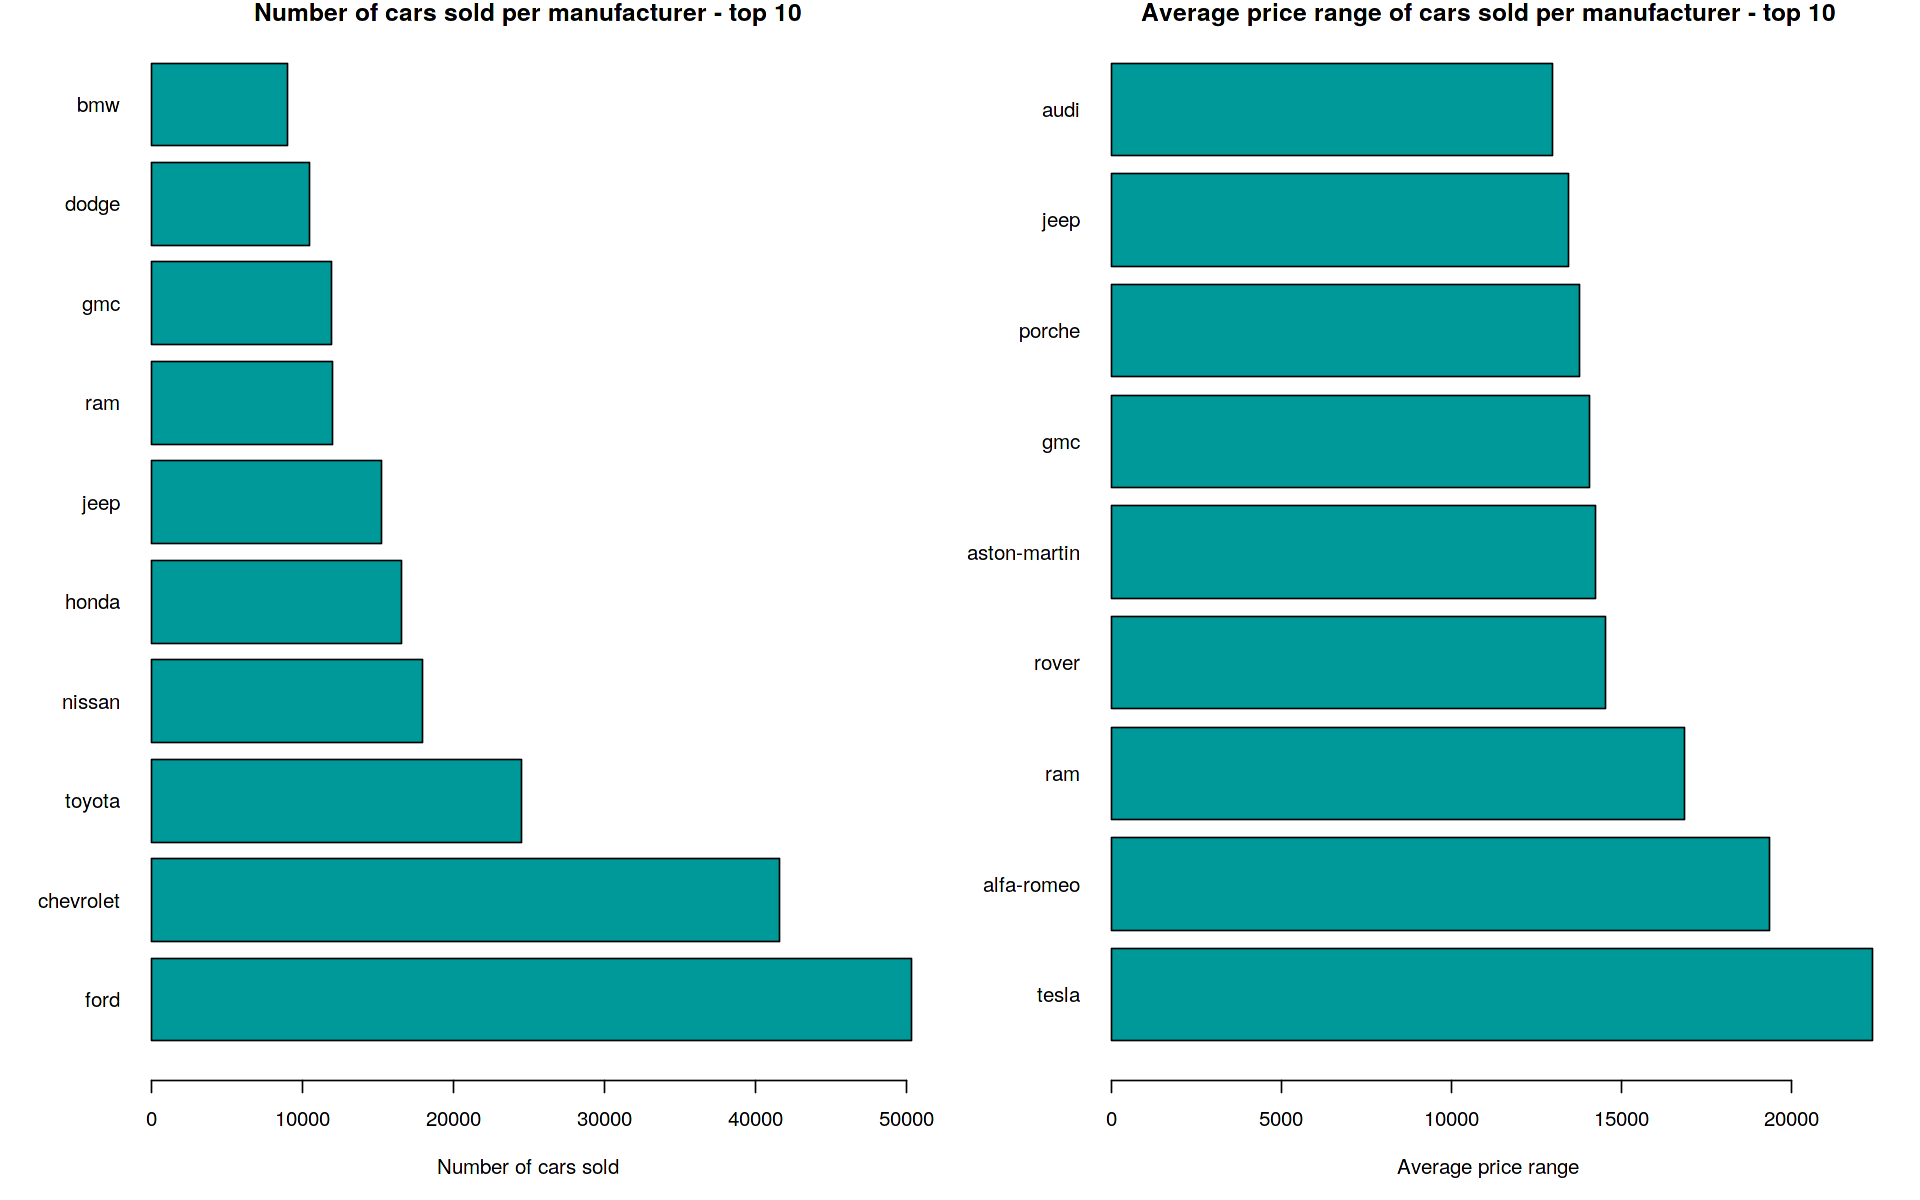

In [29]:
top_manufacturers = sort(table(df$manufacturer),decreasing = TRUE)[0:10]
par( mfrow = c(1,2), mar=c(5,6,1,2))
barplot(
    top_manufacturers,
    horiz = TRUE,
    las=TRUE,
    col = '#009999',
    xlab = 'Number of cars sold',
    main = 'Number of cars sold per manufacturer - top 10'
)
barplot(
    names.arg = top_sold$manufacturer, 
    height = top_sold$avg_price, 
    horiz = TRUE, 
    las=TRUE,
    col = '#009999',
    xlab = 'Average price range',
    main = 'Average price range of cars sold per manufacturer - top 10'
)

The first plot above shows the manufacturers with the most sold vehicles. These vehicles are most prefered by buyers according to the dataset. The same manufacturers are not ones with the cars priced at higher ranges. The following conclusions are drawn :-

* Buyers generally prefer cars at lower price ranges.
* Cars sold at high price ranges are not the cars most sold.

Next let us look at the type column which describes the type of a car. Type of a car can describe what type of cars buyers are generally looking for.

In [30]:
grouped = df %>% group_by(type) %>% summarise(avg_price = mean(price))
top_sold = head(grouped[order(- grouped$avg_price),],9)
top_sold

type        avg_price
1 pickup      16617.25 
2 other       14975.13 
3 truck       14617.34 
4 offroad     13199.23 
5 coupe       12594.72 
6 van         11627.16 
7 SUV         11514.62 
8 convertible 11512.44 
9 bus         10564.27

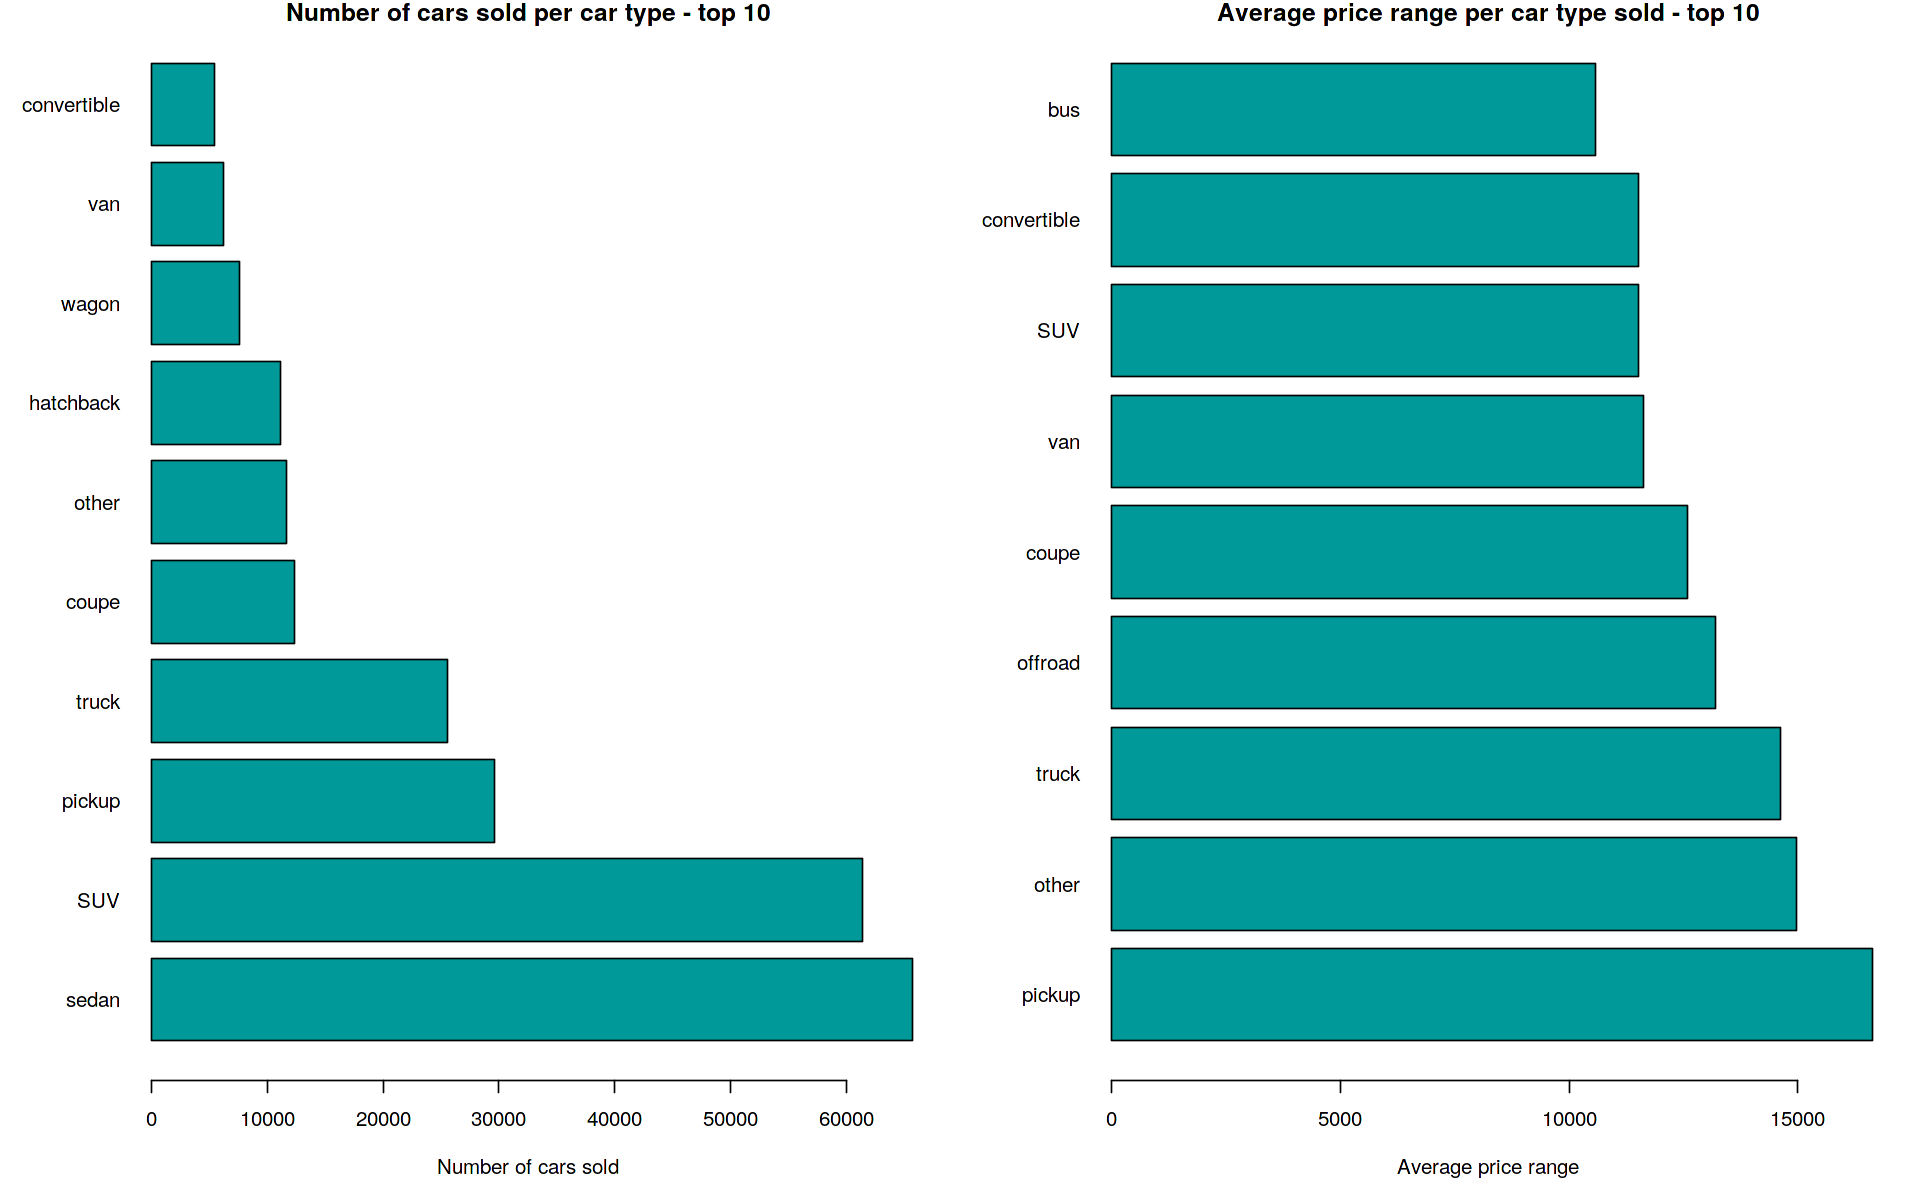

In [31]:
top_types = sort(table(df$type),decreasing = TRUE)[0:10]
par(mar=c(5,6,1,2), mfrow = c(1,2))
barplot(
    top_types,
    horiz = TRUE,
    las=TRUE,
    col = '#009999',
    xlab = 'Number of cars sold',
    main = 'Number of cars sold per car type - top 10'
)
barplot(
    names.arg = top_sold$type,
    height = top_sold$avg_price,
    horiz = TRUE,
    las = TRUE,
    col = '#009999',
    xlab = 'Average price range',
    main = 'Average price range per car type sold - top 10'
)

The first plot shows the most sold type of cars. The sedans and SUVs are most popular amongst the buyers. But these types are not the ones that are at higher price range. Pickups and trucks are at higher price ranges. This draws the conclusion that :-

* Buyers prefer car types that are not at the higher end of price range.
* Sedans and SUVs are popular among the buyers.
* High end cars are either Pickup trucks or covertibles and coupes.

The two sets of plots tells us that buyers prefer cars that are at the lower or mediocre price range.<br>
Manufacturer of a car does not directly add to the price prediction. Since no linear relationship can be established. The types column also fails to give a generalization in terms of price. A sedan can have a lower price point or a higher price point depending on alot of factors. Hence both the columns are not going to be considered.

Let us now look at the fuel column. It describes the fuel type the car consumed. Intuitvely vehicles with different fuel capabilites have diverse price ranges.

[1] "gas"      "diesel"   NA         "other"    "electric" "hybrid"  


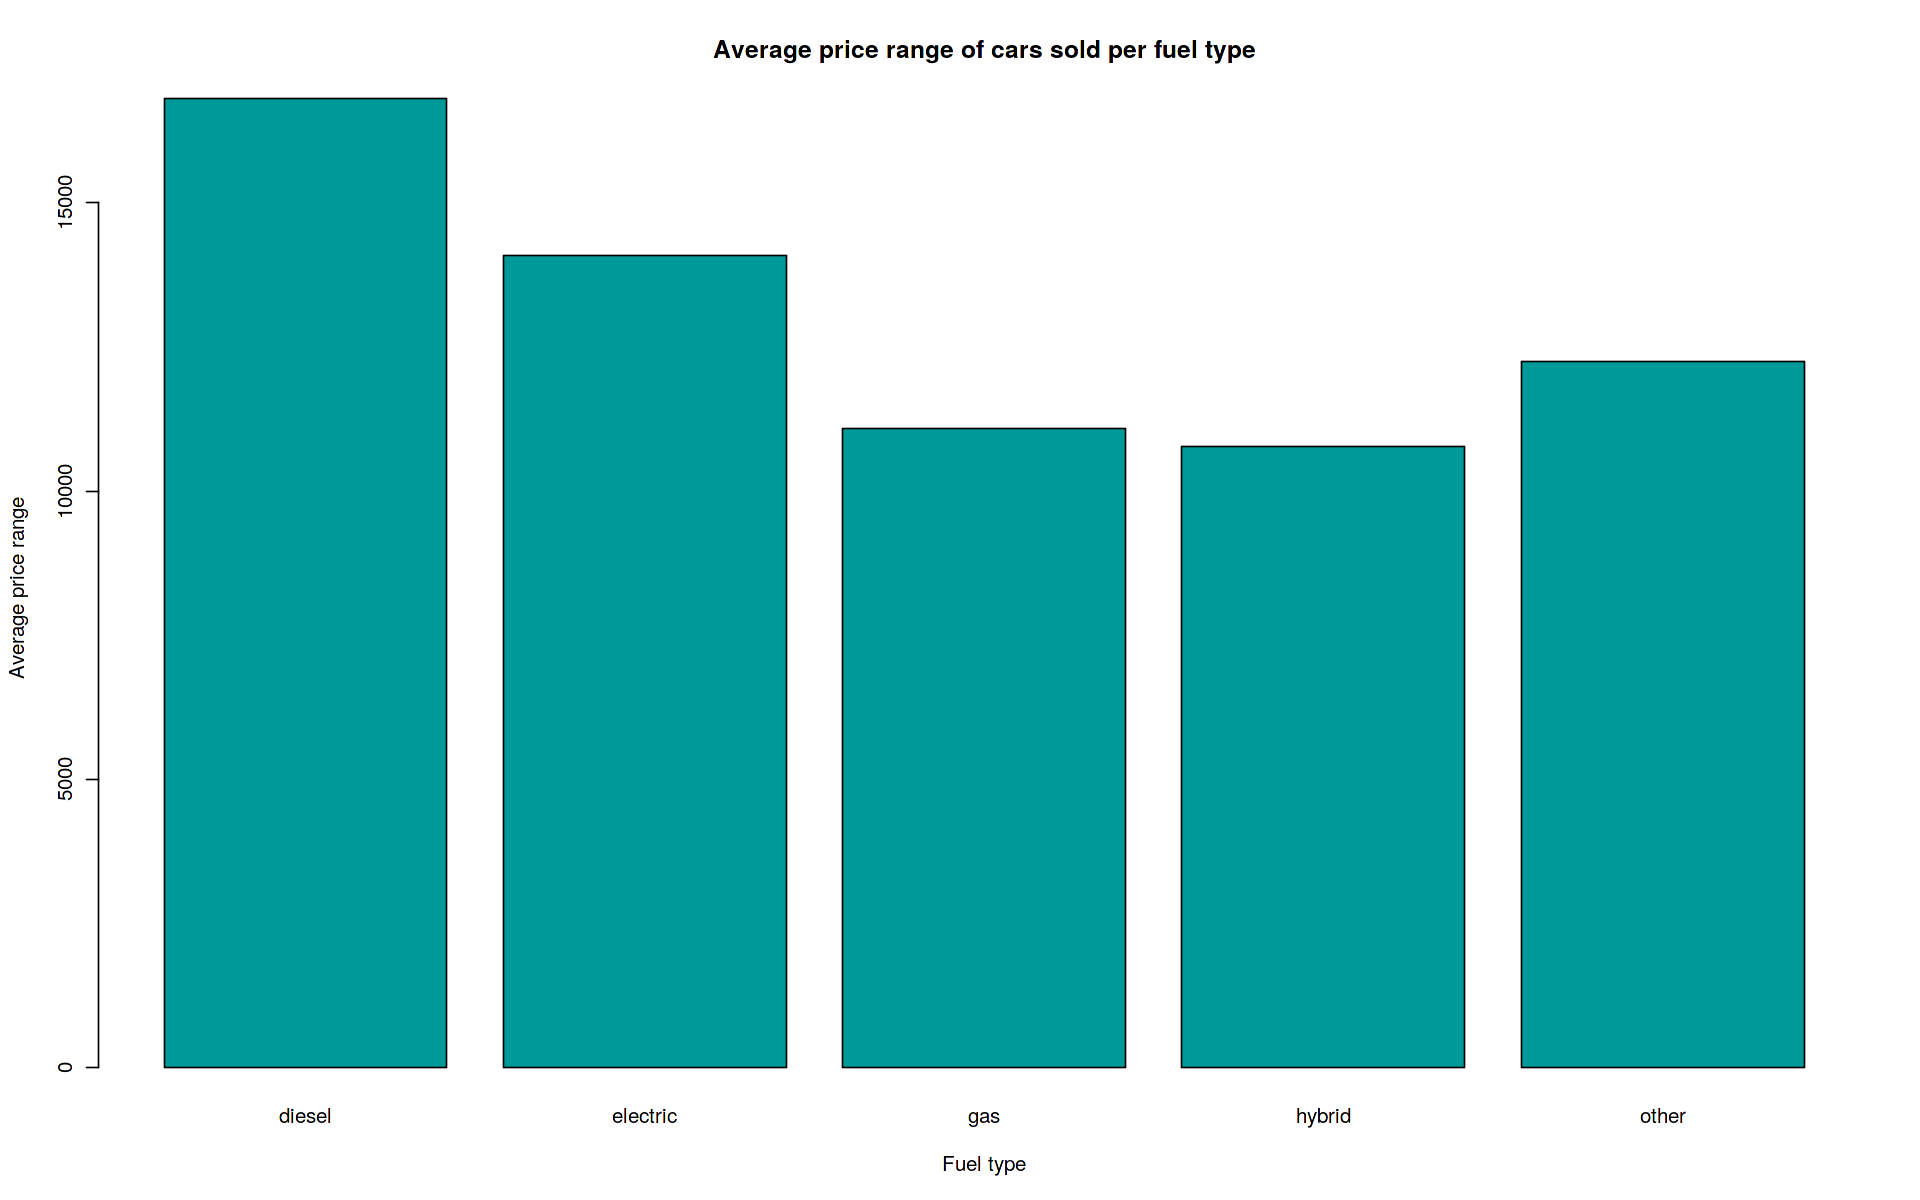

In [32]:
print(unique(df$fuel))

grouped = df %>% group_by(fuel) %>% summarise(avg_price = mean(price))
fuel_type = grouped[0:5,]
barplot(
    names.arg = fuel_type$fuel,
    height = fuel_type$avg_price,
    col = '#009999',
    xlab = 'Fuel type',
    ylab = 'Average price range',
    main = 'Average price range of cars sold per fuel type'
)

As assumed, the prices of cars differ between different fuel types. The cars running on disel or electricity are high priced as compared to the rest. Hybrid and gas cars are among the lowest. Fuel type can be a good predictor of the price as it can clearly differentitate between cars and its price range.<br>

The title_status column describes titles associated with the car. A car can be rebuilt, salvaged or clean (almost brand new). A car can even be under lien i.e. under a loan. Intuitively, this column should be a good predictor for the price of a car. Since the title attached to a car can be a deciding factor of its price. A car with the clean status will have a good price as compared to a salvaged or rebuilt car.

In [33]:
print(unique(df$title_status))

grouped = df %>% group_by(title_status) %>% summarise(avg_price = mean(price))
car_status = grouped[1:6,]
car_status

[1] "clean"      "salvage"    "rebuilt"    "lien"       NA          
[6] "missing"    "parts only"


title_status avg_price
1 clean        11482.988
2 lien         16417.128
3 missing       2698.858
4 parts only    3742.500
5 rebuilt      10064.677
6 salvage       8596.156

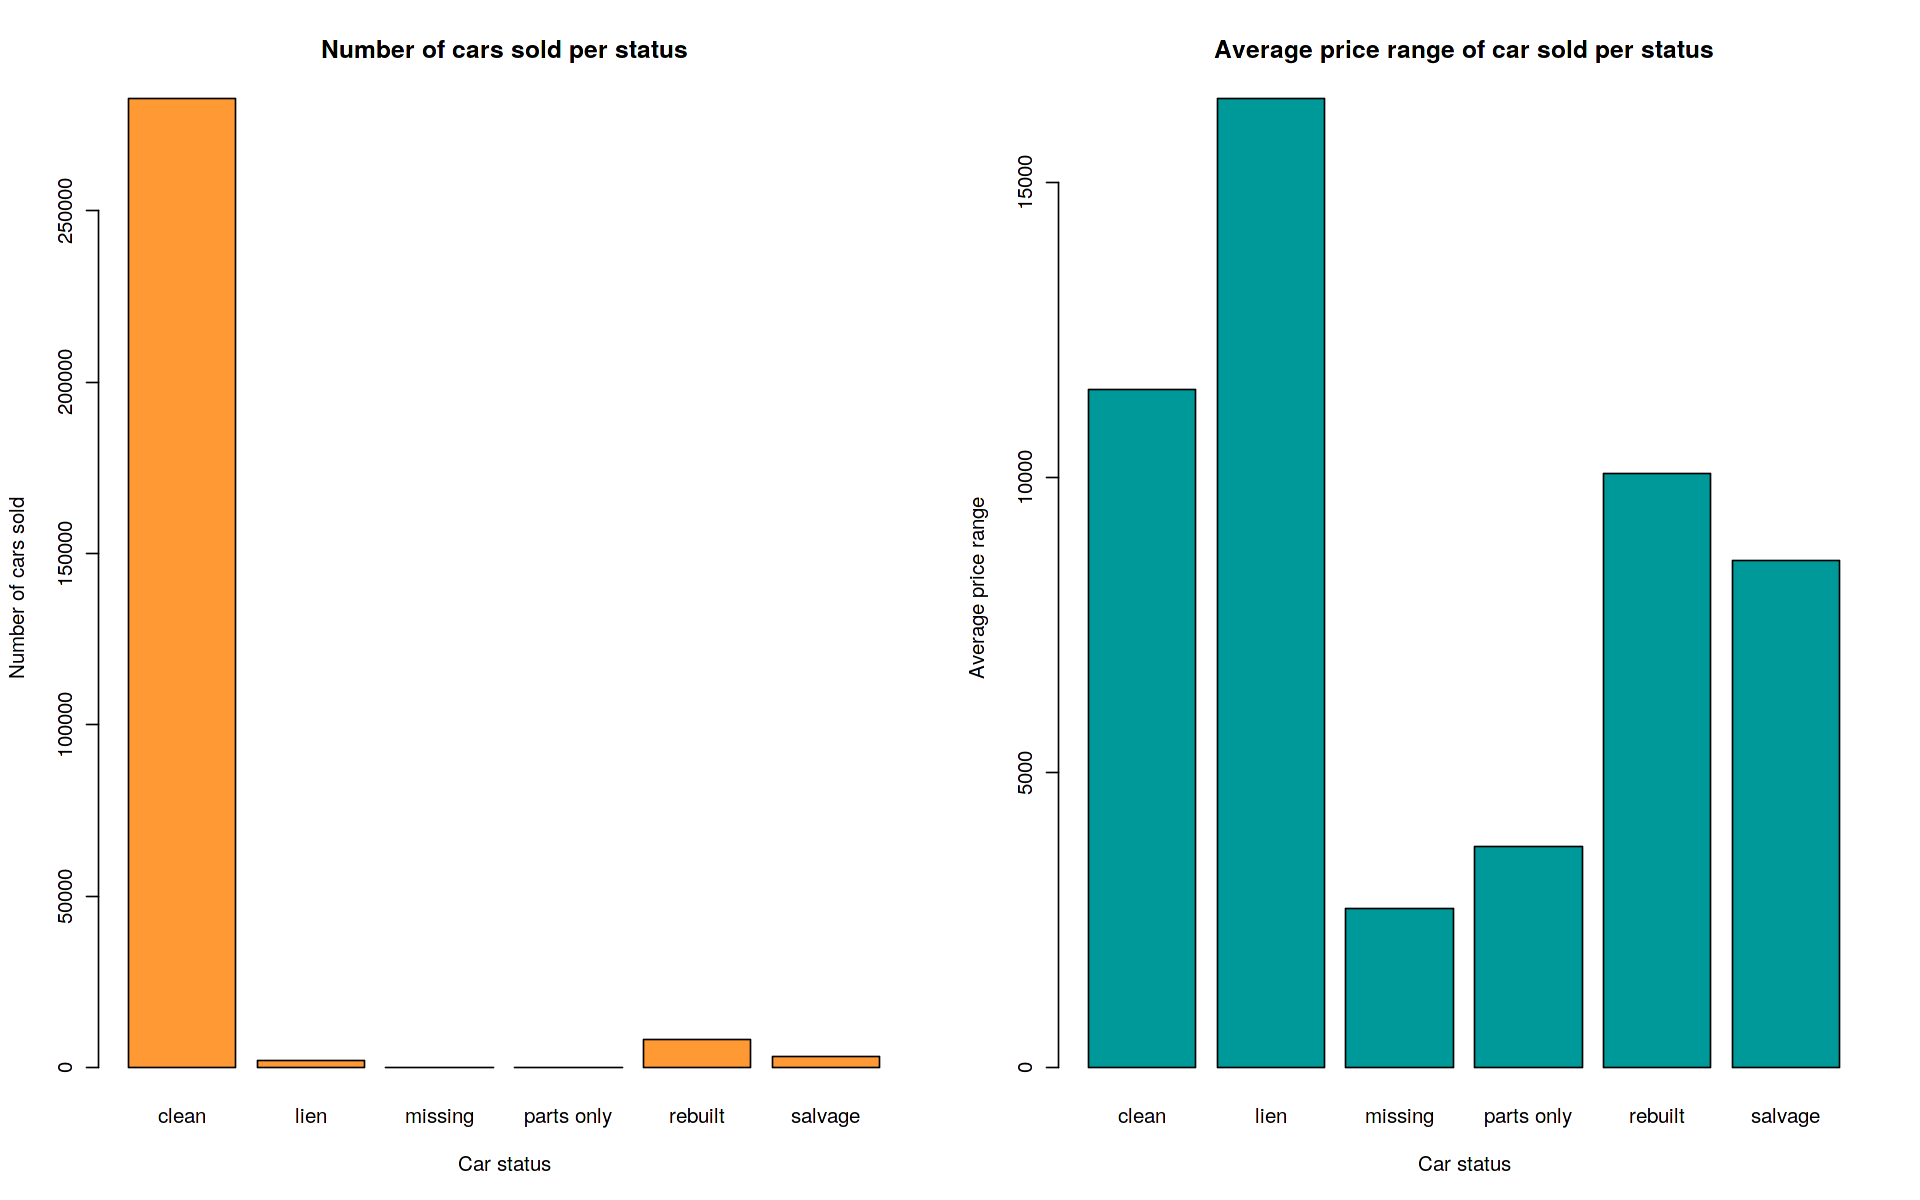

In [34]:
par(mfrow = c(1,2))
barplot(
    table(df$title_status),
    xlab = 'Car status',
    ylab = 'Number of cars sold',
    col = '#ff9933',
    main = 'Number of cars sold per status'
)
barplot(
    names.arg = car_status$title_status,
    height = car_status$avg_price,
    col = "#009999",
    xlab = 'Car status',
    ylab = 'Average price range',
    main = 'Average price range of car sold per status'
)

The following conclusions can be drawn from the above plot :-
* Cars sold with the lien status i.e. have bank loan over them, are sold in the higher price range.
* Cars sold with clean status are most sold on craigslist.
* Rebuilt and salvaged cars are sold more than cars that have lien on it.

As hypothesised before, all statuses show differences in price ranges and hence can be estimated to be a good predictor for the price of a car.

In [35]:
print(unique(df$transmission))

grouped = df %>% group_by(transmission) %>% summarise(avg_price = mean(price))
transmission_types = grouped[1:3,]
transmission_types

[1] "automatic" NA          "manual"    "other"    


transmission avg_price
1 automatic    11182.669
2 manual        9529.586
3 other        18130.560

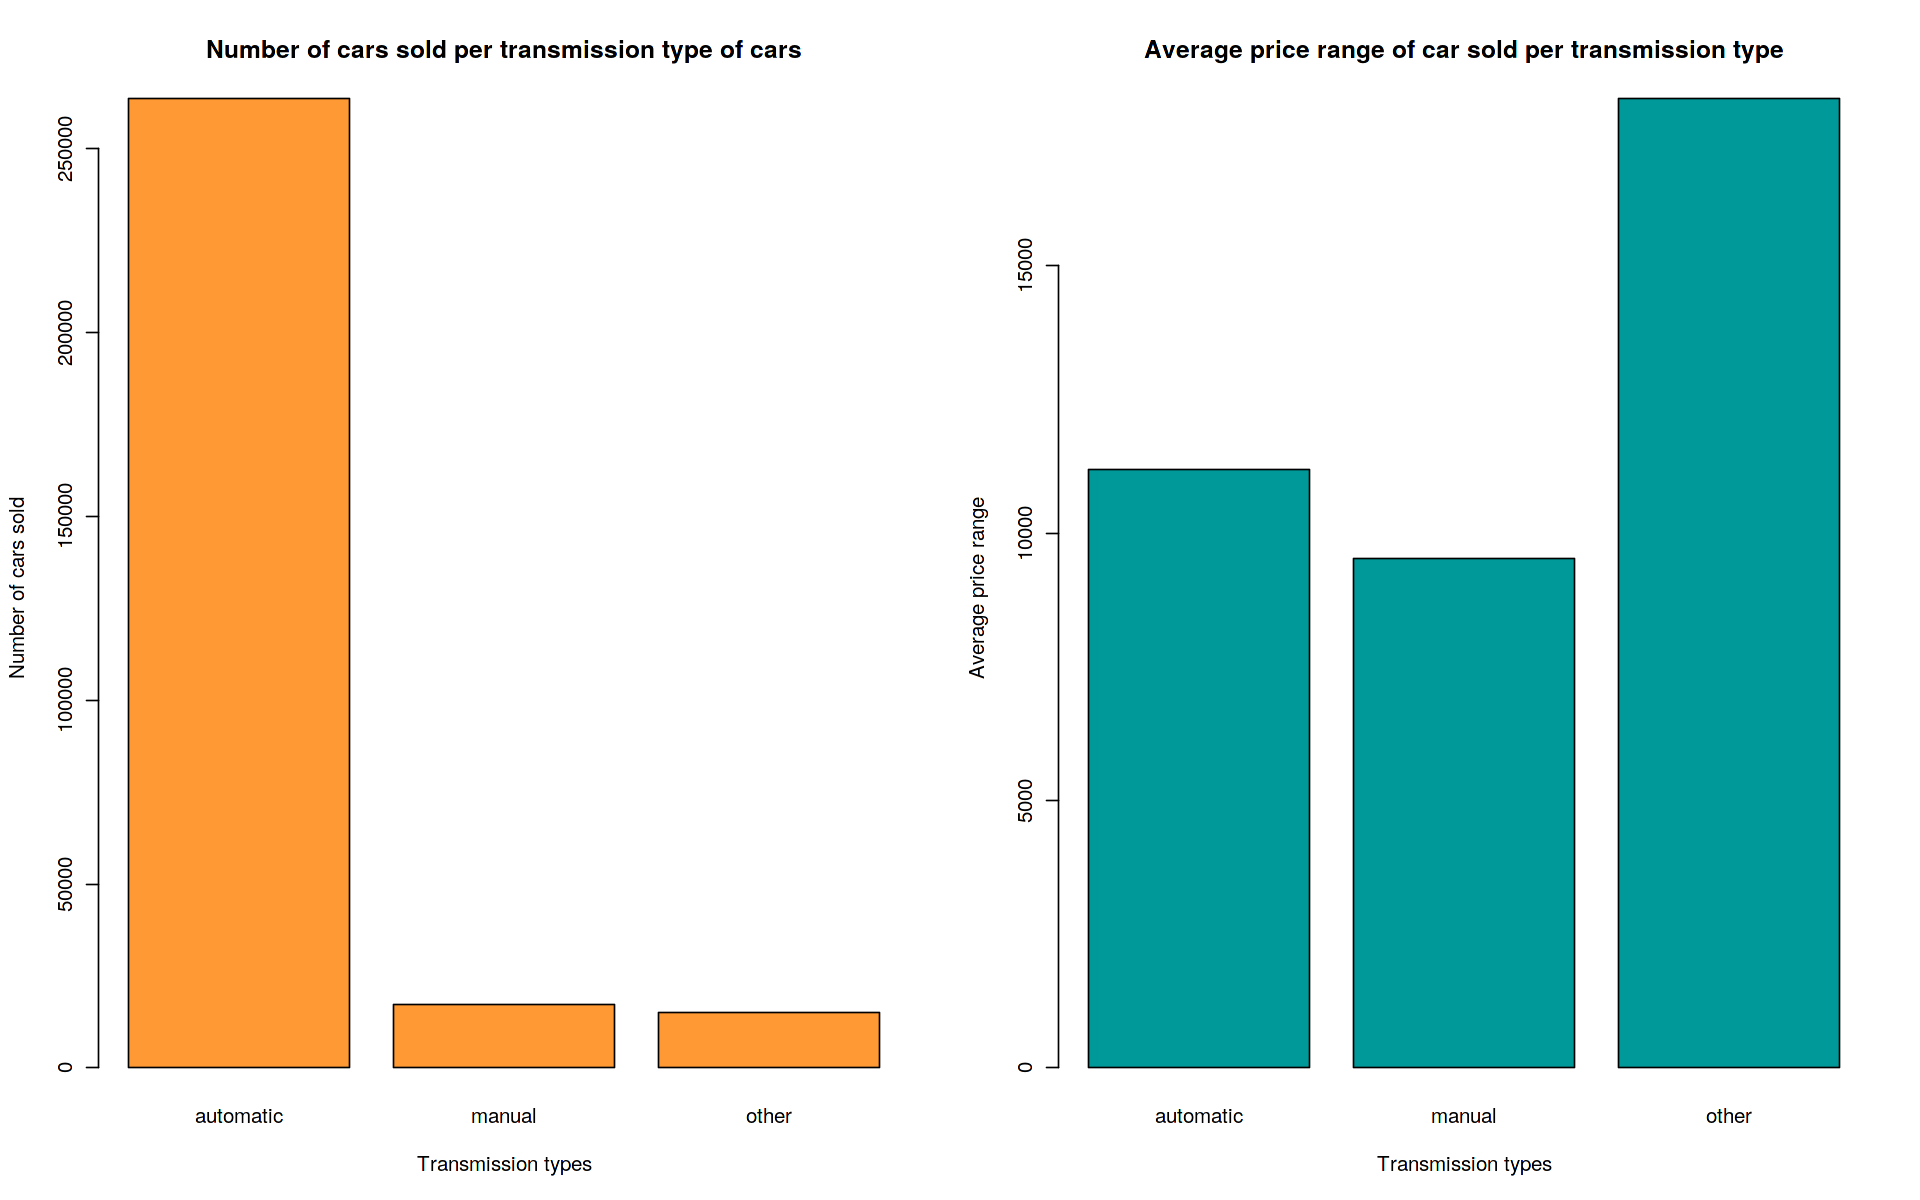

In [36]:
par(mfrow = c(1,2))
barplot(
    table(df$transmission),
    xlab = 'Transmission types',
    ylab = 'Number of cars sold',
    col = '#ff9933',
    main = 'Number of cars sold per transmission type of cars'
)
barplot(
    names.arg = transmission_types$transmission,
    height = transmission_types$avg_price,
    col = "#009999",
    xlab = 'Transmission types',
    ylab = 'Average price range',
    main = 'Average price range of car sold per transmission type'
)

Conclusions :-
* Automatic cars are most sold on craigslist, most of the cars listed are automatic
* Cars with manual or other types of transmission are less sold.
* There is not much difference between average prices of cars that are automatic or cars that are manual.

These conclusions lead to the argument that, transmission of a vehcile offers limited influence in predicting the price of a car.<br>
The next column to analyze is the drive column. The drive column describes the drive wheel of the car. It could be forward wheel drive or rear wheel drive or all four wheel drive.

In [37]:
print(unique(df$drive))

grouped = df %>% group_by(drive) %>% summarise(avg_price = mean(price))
drive_types = grouped[1:3,]
drive_types

[1] NA    "rwd" "fwd" "4wd"


drive avg_price
1 4wd   13886.081
2 fwd    8879.667
3 rwd   11890.166

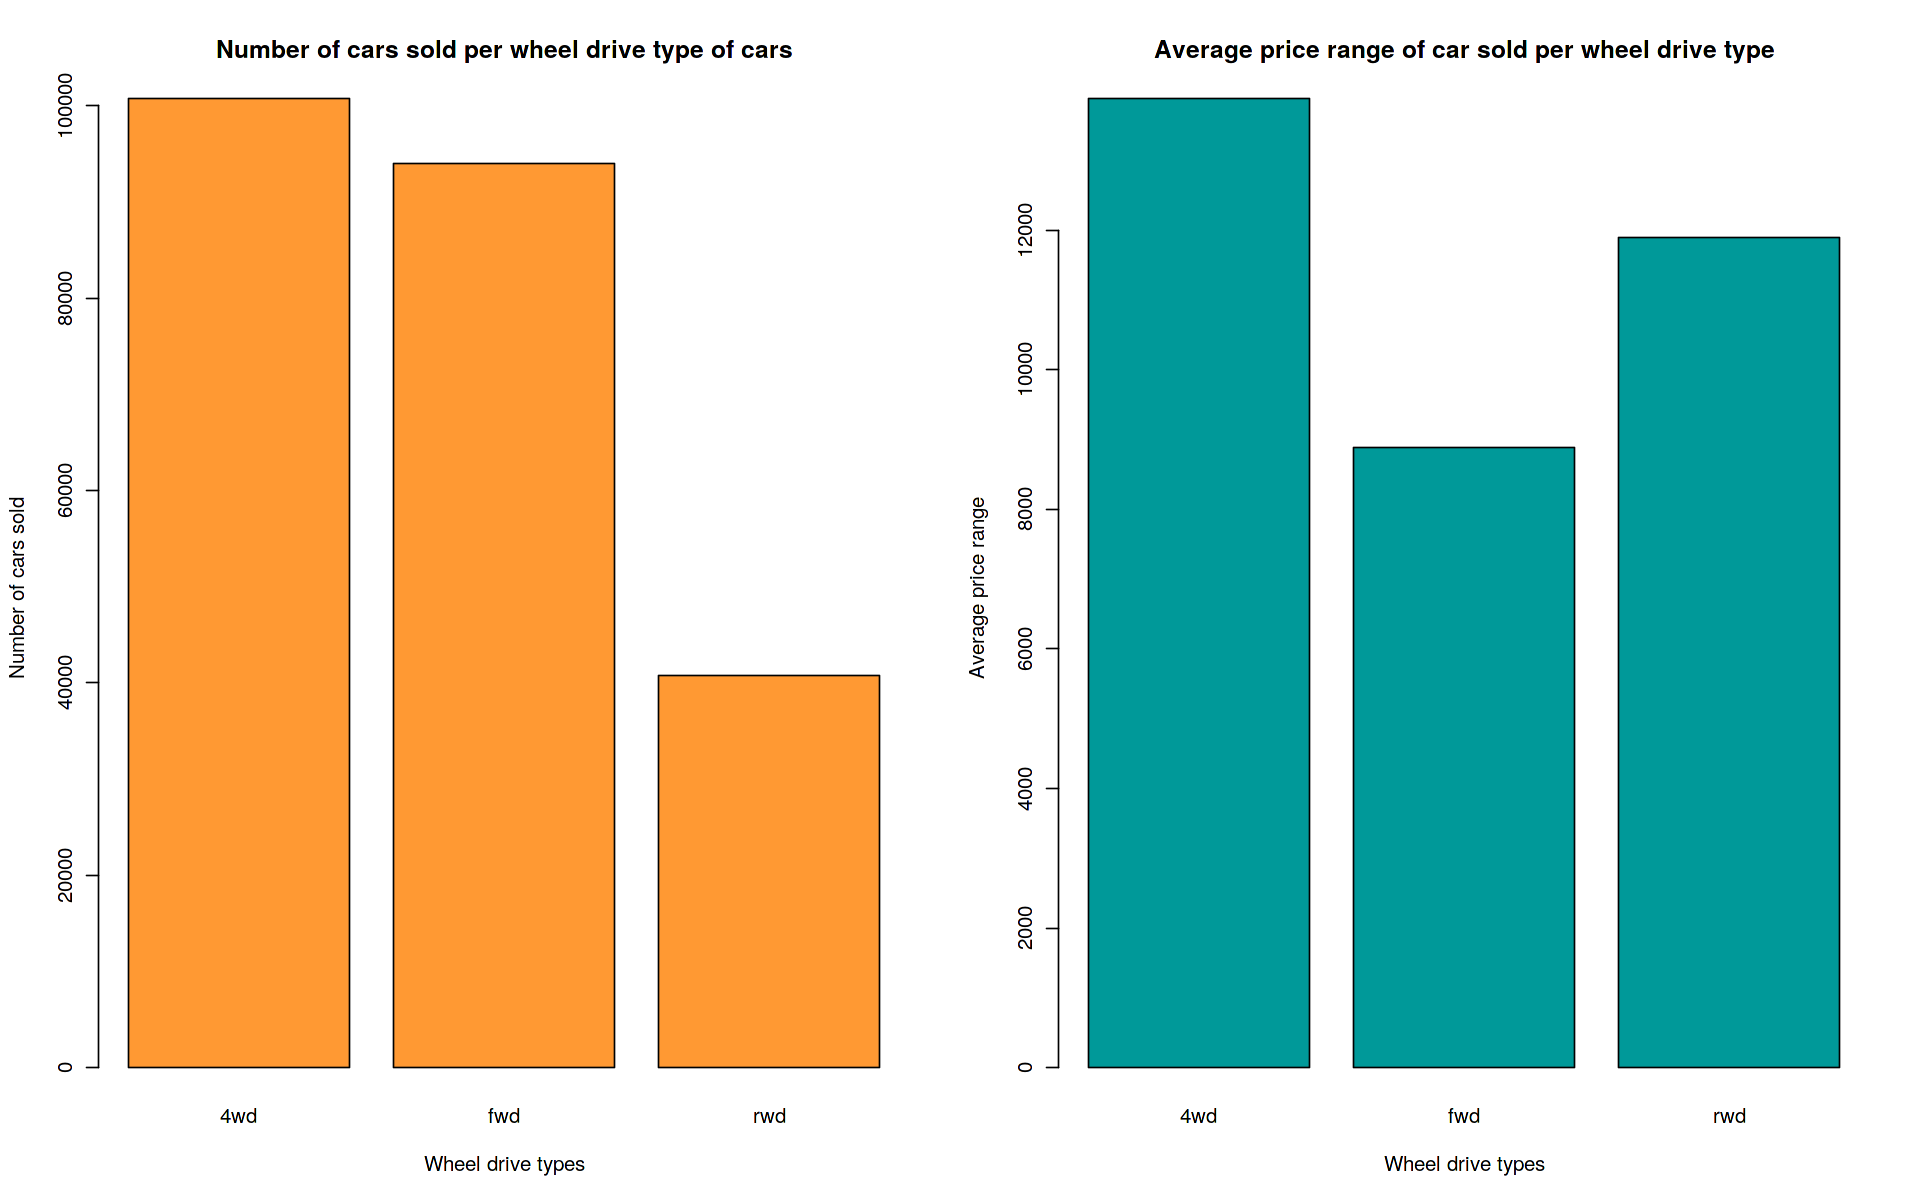

In [38]:
par(mfrow = c(1,2))
barplot(
    table(df$drive),
    xlab = 'Wheel drive types',
    ylab = 'Number of cars sold',
    col = '#ff9933',
    main = 'Number of cars sold per wheel drive type of cars'
)
barplot(
    names.arg = drive_types$drive,
    height = drive_types$avg_price,
    col = "#009999",
    xlab = 'Wheel drive types',
    ylab = 'Average price range',
    main = 'Average price range of car sold per wheel drive type'
)

The conclusions :-

* 4 wheel drive cars are most sold and has a higher price range.
* rear wheel drive cars are least sold but has a higher price range.
* forward wheel drive cars are cheapest as compared to the rest.


The only columns left to analyze now are the Latitude and Longitude, identifying the location of car being sold online. Locations usually have effects on the prices of cars. Different states and regions have different tax brackets and different purchasing power thus bringing a change in prices for a car.
The plot below maps all these locations on world map.

In [39]:
df = filter(df,!(is.na(df$lat) | is.na(df$long)))

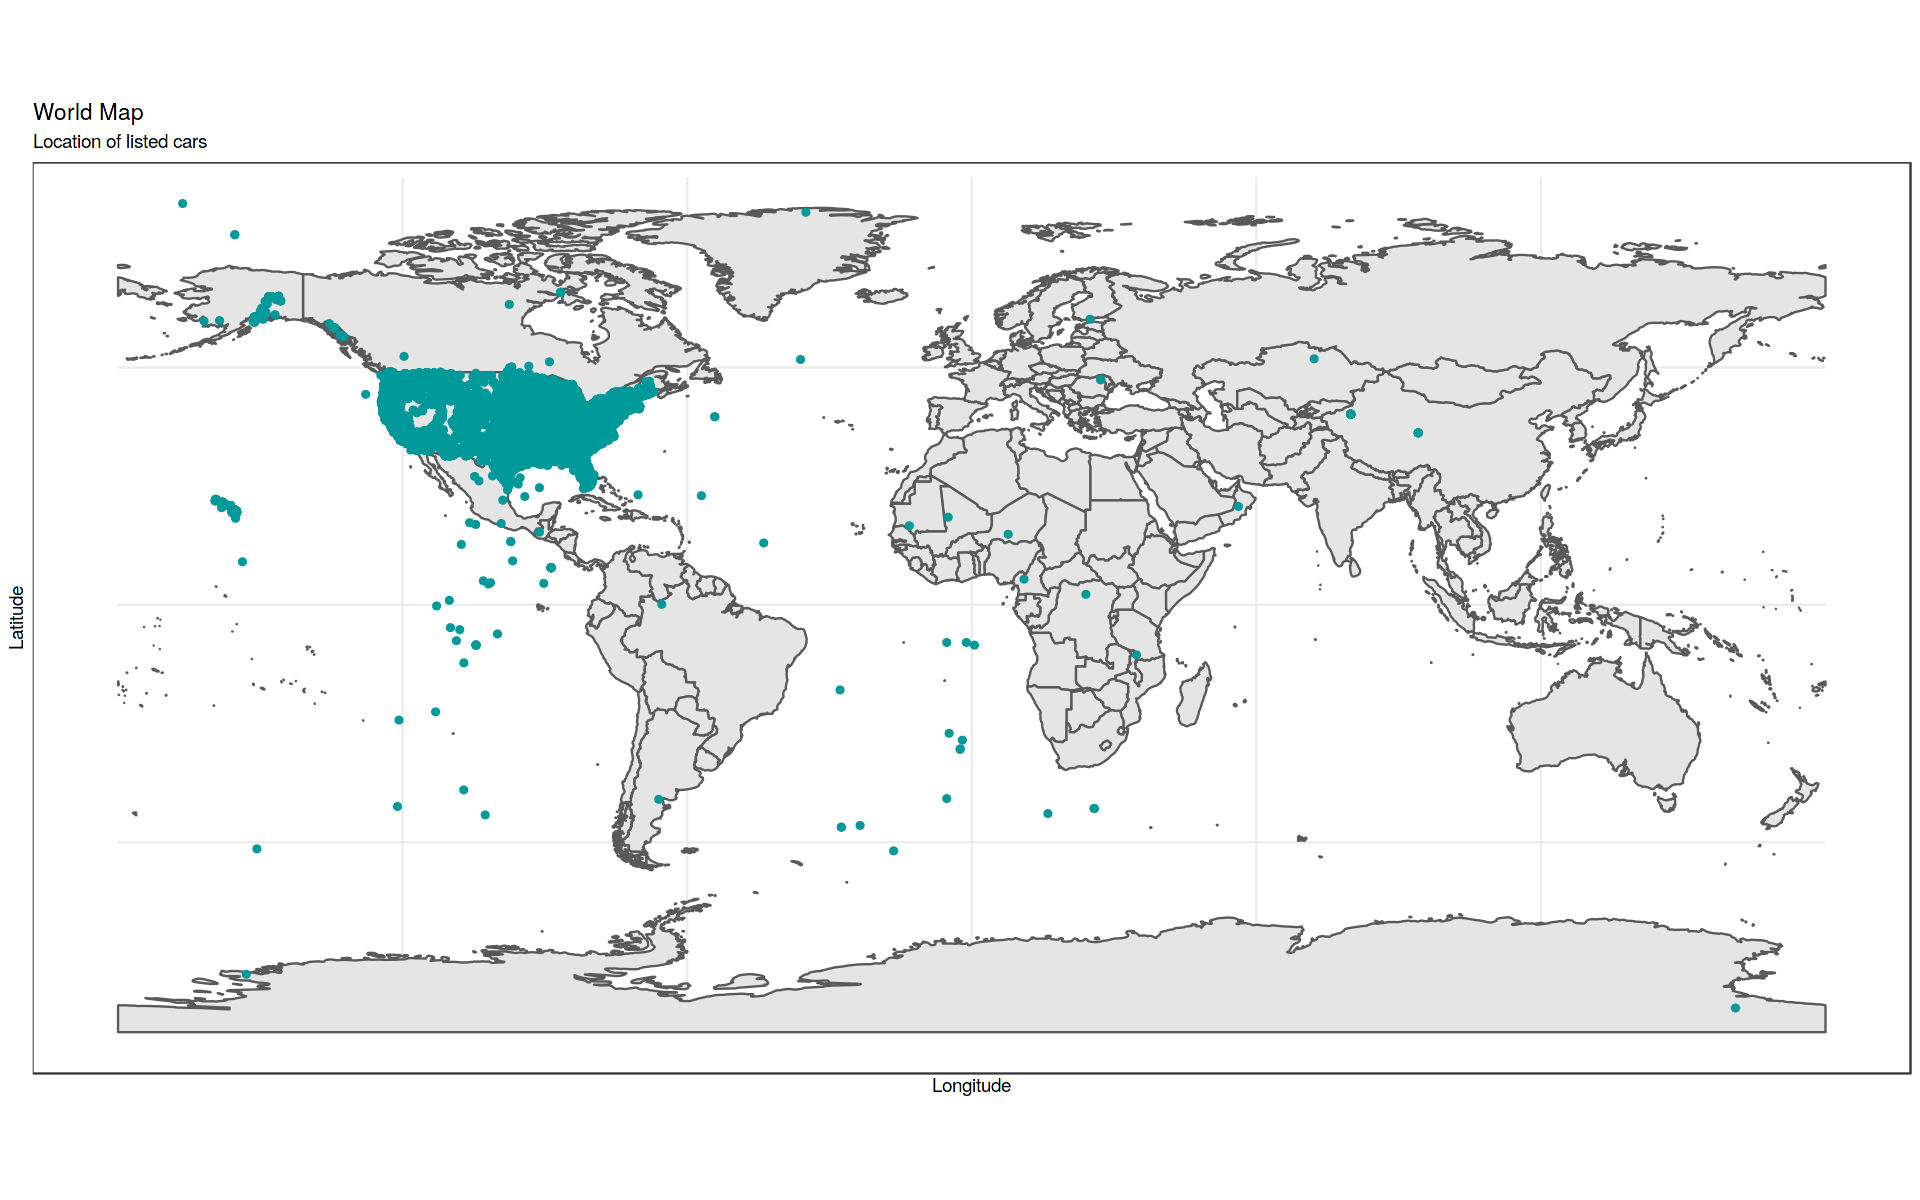

In [40]:
# us = map_data('world')
# ggplot() + geom_polygon(data = us, aes(y = lat,x = long, group = group), fill='light grey', color='black') +
# geom_point(data = df, aes(x = long, y = lat), color = '#009999')

theme_set(theme_bw())
world = ne_countries(scale = 'medium', returnclass = 'sf')
ggplot(data = world) + geom_sf() + geom_point(data = df, aes(x=long, y=lat), color = '#009999') +
ggtitle("World Map", subtitle = 'Location of listed cars') +
xlab("Longitude") +
ylab("Latitude")

There are alot of outliers in these columns. Some of the locations are over the oceans which is obviously faulty. Since majority of the points lie in the United States of America, we will use the `interquartile range` (IQR) method to remove the outliers. Once the outliers are removed, the locations are plotted against the United States of America map to identify the spread of data.

In [41]:
stats_lng = summary(df$long)
interquartile = stats_lng[5] - stats_lng[2]
thresh = interquartile * 1.5
upper = stats_lng[5] + thresh
lower = stats_lng[2] - thresh
df = filter(df,between(df$long,lower,upper))

stats_lt = summary(df$lat)
interquartile = stats_lt[5] - stats_lt[2]
thresh = interquartile * 1.5
upper = stats_lt[5] + thresh
lower = stats_lt[2] - thresh
df = filter(df,between(df$lat,lower,upper))
head(df,5)

price year manufacturer fuel odometer title_status transmission drive type 
1 10299 2012 acura        gas   90186   clean        automatic    NA    other
2  9500 2011 jaguar       gas   85000   clean        automatic    NA    NA   
3  3995 2004 honda        gas  212526   clean        automatic    fwd   SUV  
4 12995 2015 kia          gas   85127   clean        automatic    4wd   wagon
5 10995 2014 chevrolet    gas  112383   clean        automatic    fwd   SUV  
  lat     long    
1 35.7636 -78.7443
2 36.1032 -79.8794
3 35.7636 -78.7443
4 35.7636 -78.7443
5 35.7636 -78.7443

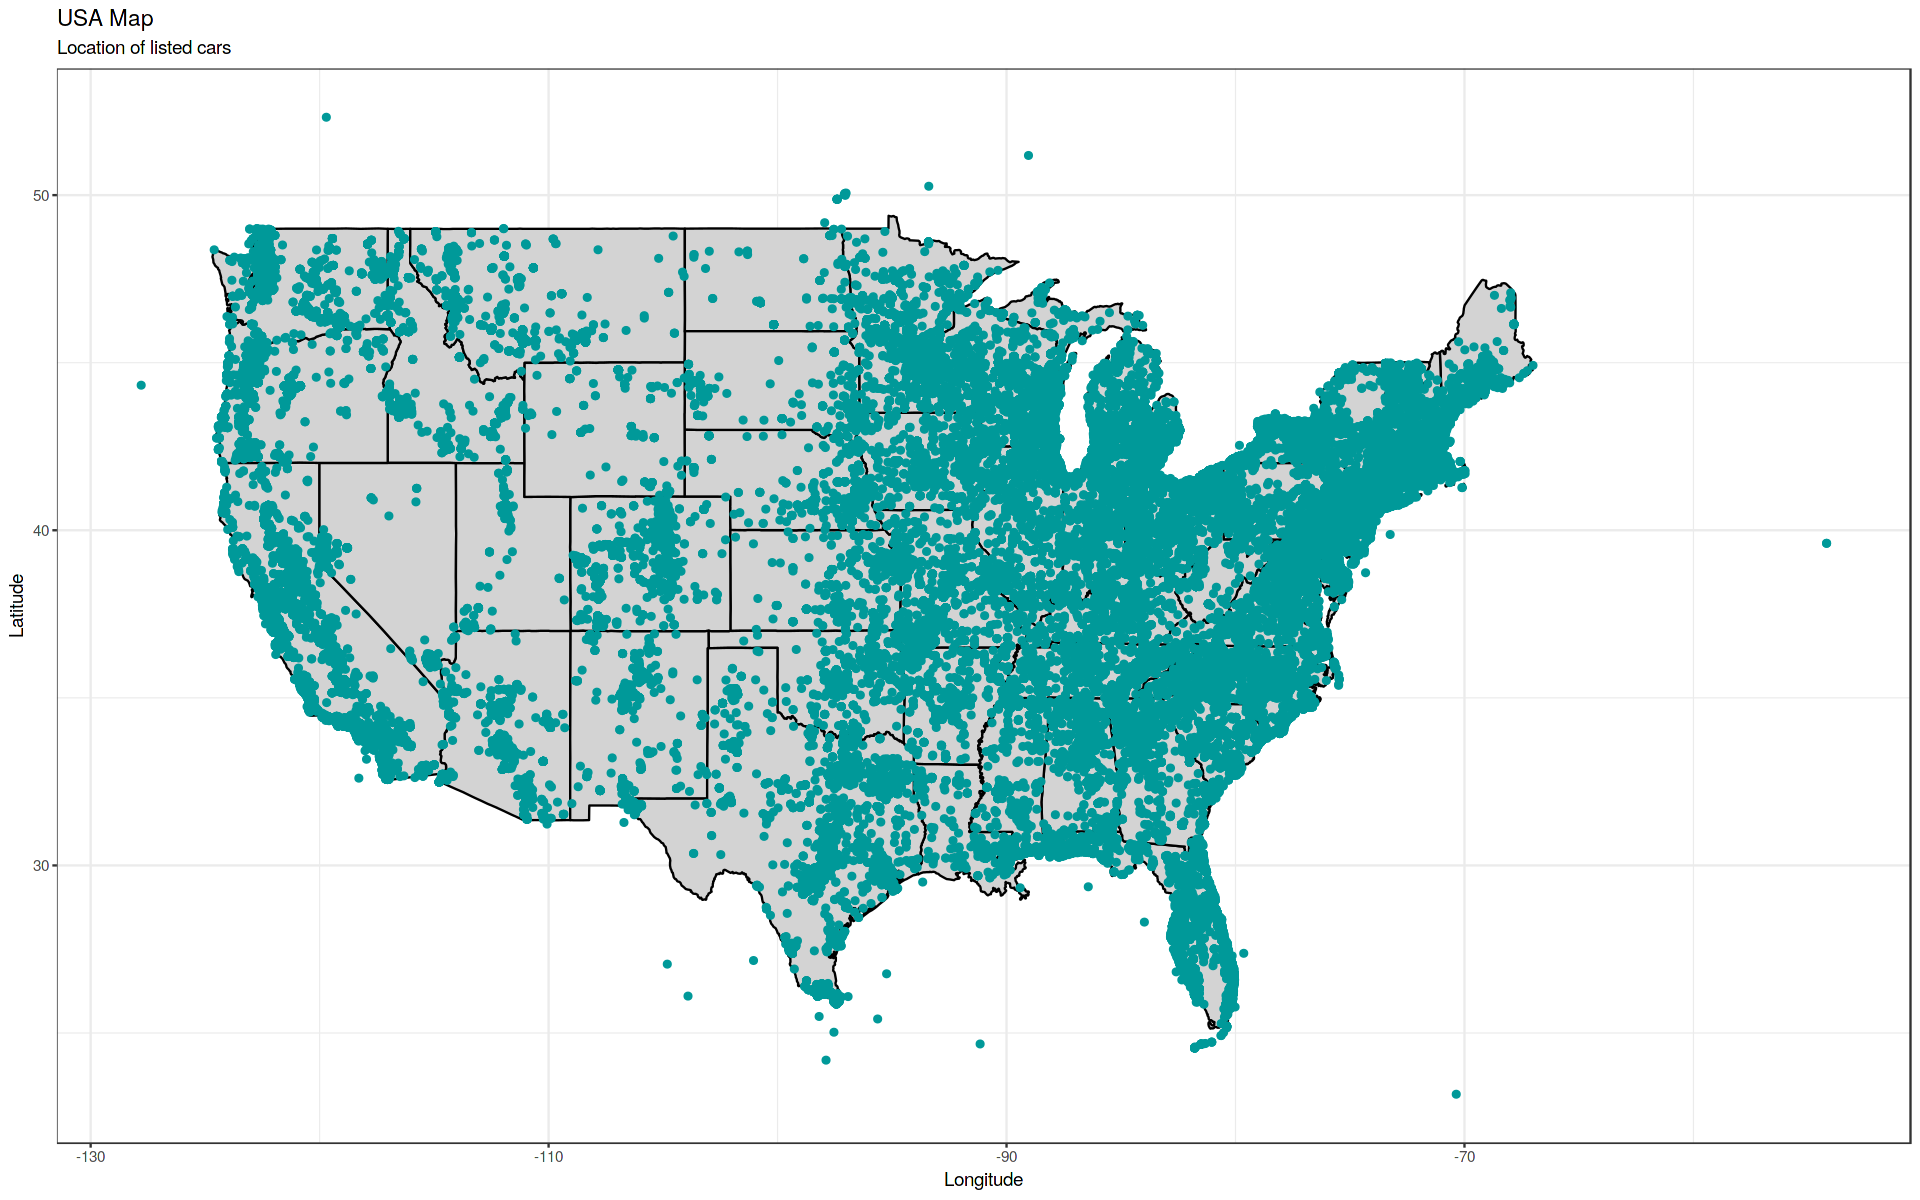

In [42]:
us = map_data('state')
ggplot() + geom_polygon(data = us, aes(y = lat,x = long, group = group), fill='light grey', color='black') +
geom_point(data = df, aes(x = long, y = lat), color = '#009999') +
ggtitle("USA Map", subtitle = 'Location of listed cars') +
xlab("Longitude") +
ylab("Latitude")

We can clearly see the high density areas where cars are listed from on craigslist. Location as discussed is an important factor and hence the *Latitude* and *Longitude* values cannot be ignored. To get more meaning out of the data, we will apply clustering algorithm, K-means to find clusters region wise in the data.

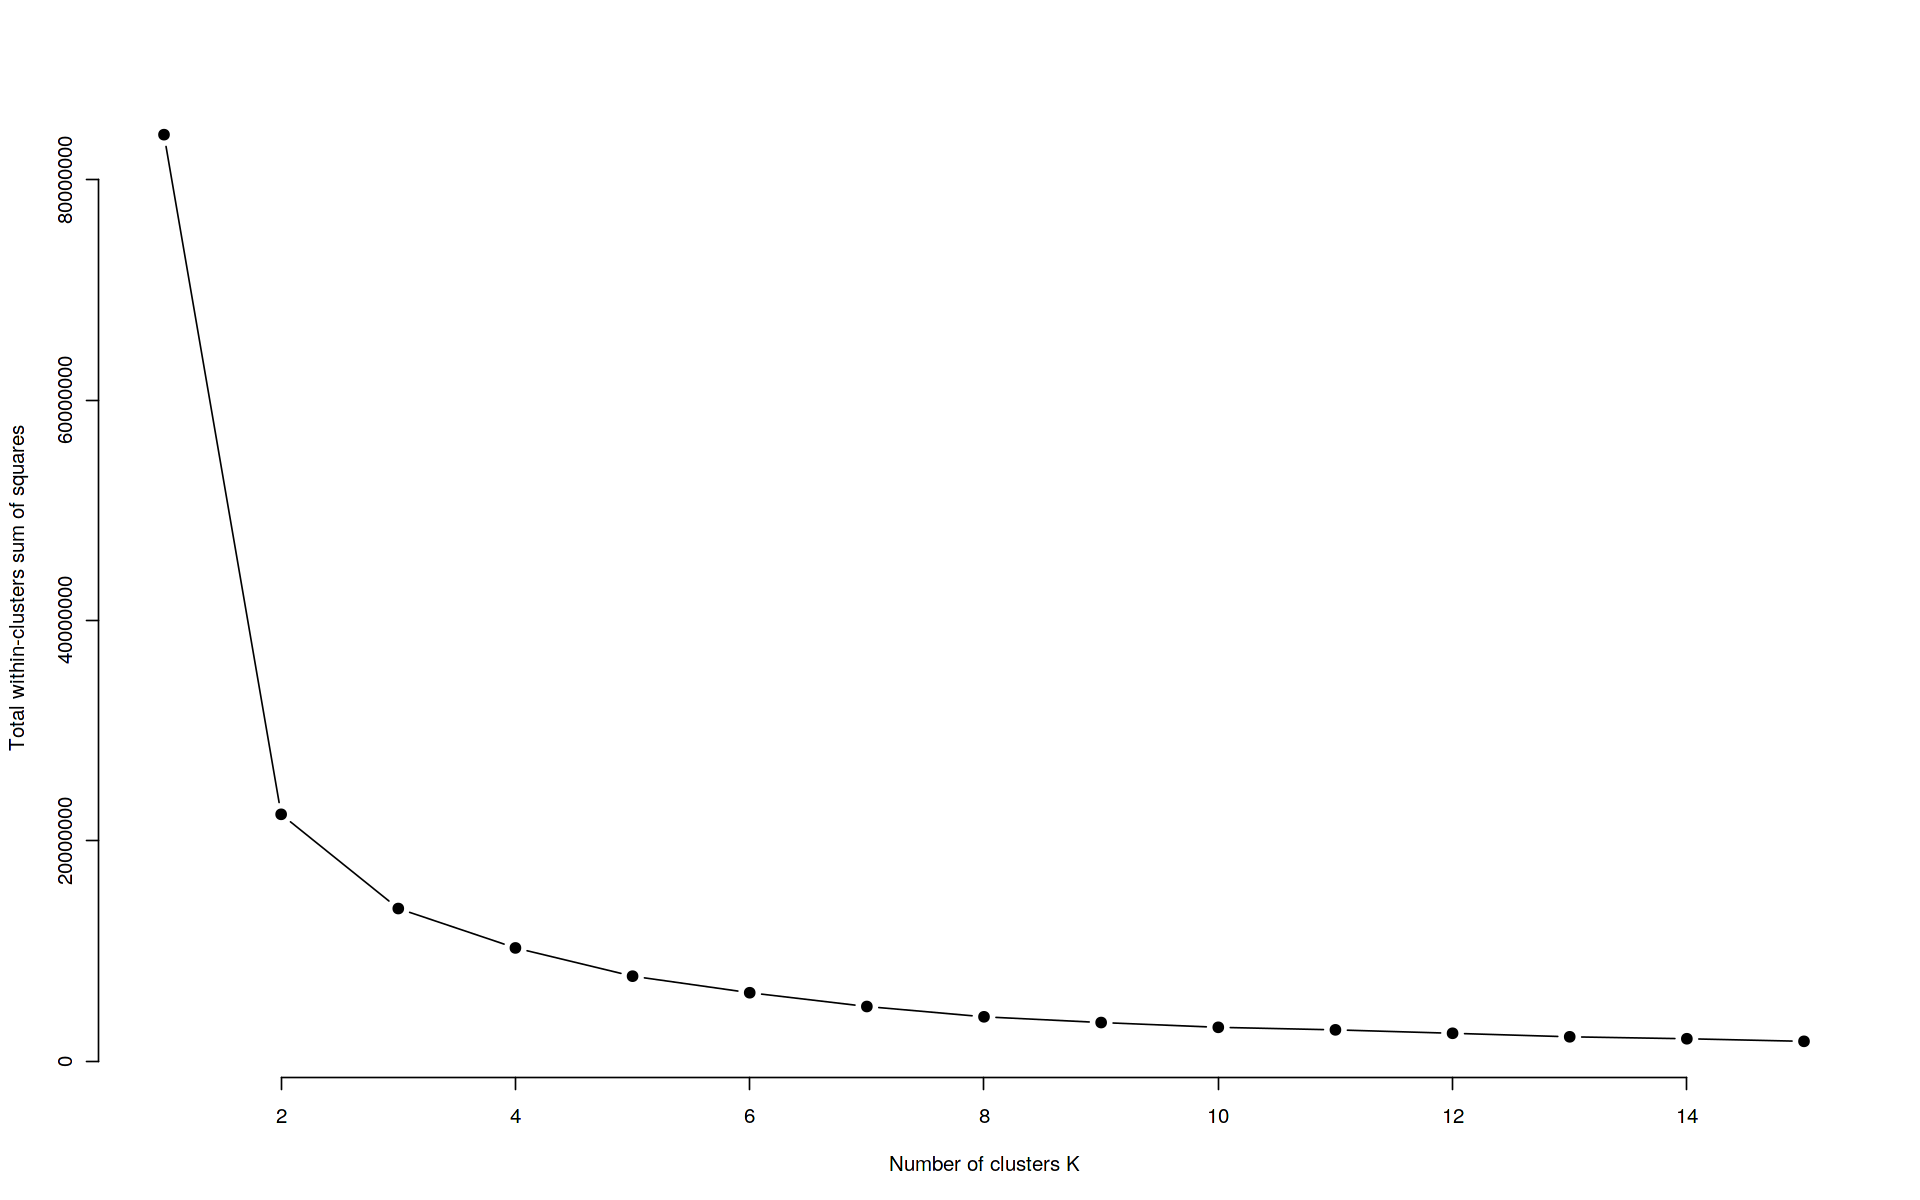

In [43]:
set.seed(123)
spatial_points = df[,c('lat','long')]

wss <- function(k) {
  kmeans(spatial_points, k, nstart = 10 )$tot.withinss
}

k.values <- 1:15

wss_values <- map_dbl(k.values, wss)

plot(k.values, wss_values,
       type="b", pch = 19, frame = FALSE, 
       xlab="Number of clusters K",
       ylab="Total within-clusters sum of squares")

#fviz_nbclust(df, kmeans, method = "wss")

The *Elbow Method* gives us the optimal number of clusters to be chosen. The plot suggests that an optimal number of clusters would be 6.

In [44]:
mod = kmeans(spatial_points, 6, nstart = 25)
print(mod$centers)

       lat       long
1 41.90470  -87.28916
2 35.41935  -98.72366
3 35.79967 -117.86442
4 40.82153  -75.08626
5 32.64633  -83.32673
6 45.73295 -119.66174


Now that we have the clusters, we can view the clusters on the map as below. It shows us the area under each cluster formed.

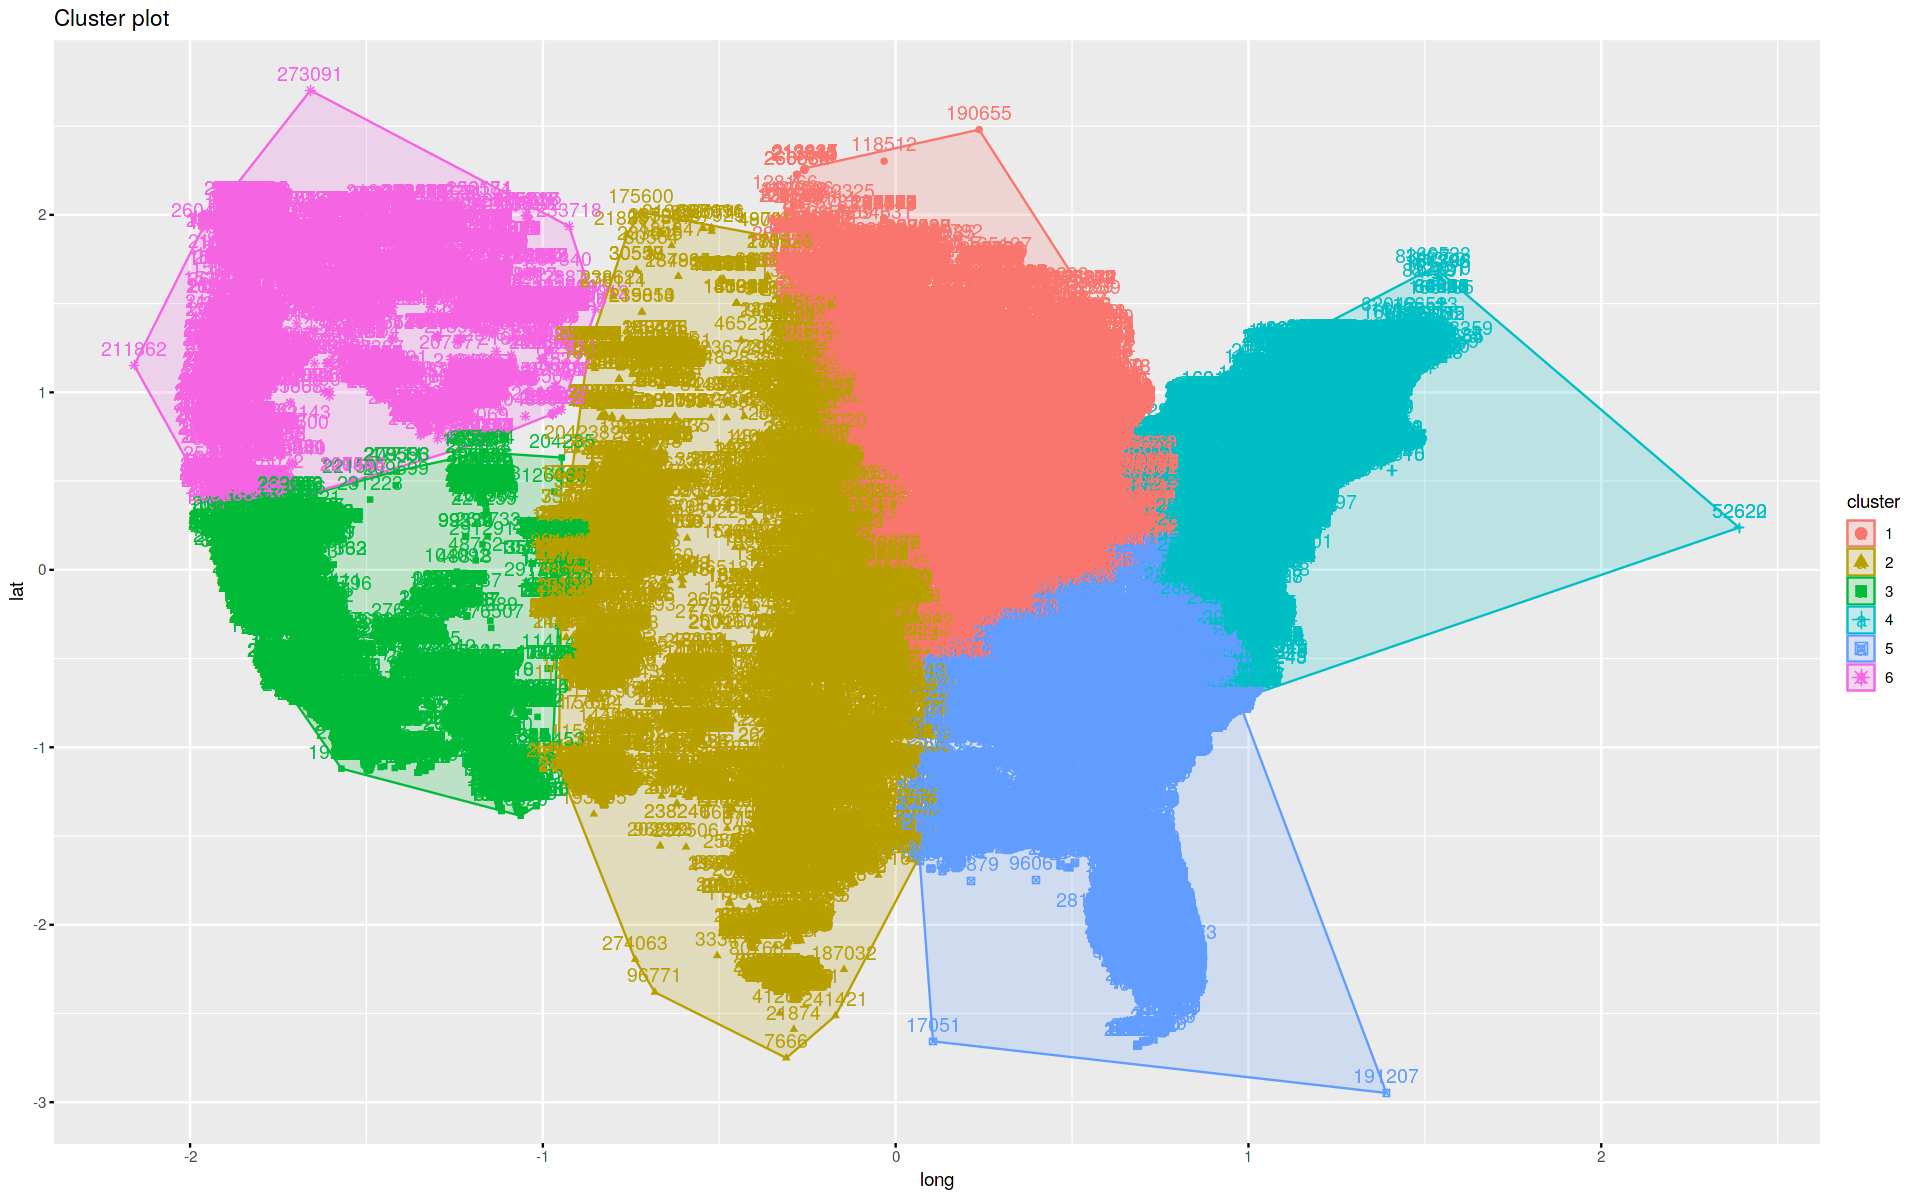

In [45]:
fviz_cluster(mod,data = spatial_points[,c('long','lat')])

We can use these clusters as location information and see if it adds to the dataset and predictive modeling. Since the Latitude and Longitude values are geospatial values, they cannot exactly show a linear relationship, but hopefully these cluster values will.

In [46]:
df['region'] = mod$cluster
head(df,5)

price year manufacturer fuel odometer title_status transmission drive type 
1 10299 2012 acura        gas   90186   clean        automatic    NA    other
2  9500 2011 jaguar       gas   85000   clean        automatic    NA    NA   
3  3995 2004 honda        gas  212526   clean        automatic    fwd   SUV  
4 12995 2015 kia          gas   85127   clean        automatic    4wd   wagon
5 10995 2014 chevrolet    gas  112383   clean        automatic    fwd   SUV  
  lat     long     region
1 35.7636 -78.7443 5     
2 36.1032 -79.8794 5     
3 35.7636 -78.7443 5     
4 35.7636 -78.7443 5     
5 35.7636 -78.7443 5

Now that we have all the independent variables ready, we will build the model. 

In [47]:
rm_cols = c(
    'manufacturer'
)

df = df[!names(df) %in% rm_cols]
df = na.omit(df)
df = filter(df,df$price != 0)
head(df,5)

price year fuel odometer title_status transmission drive type        lat    
1  3995 2004 gas  212526   clean        automatic    fwd   SUV         35.7636
2 12995 2015 gas   85127   clean        automatic    4wd   wagon       35.7636
3 10995 2014 gas  112383   clean        automatic    fwd   SUV         35.7636
4  3995 2007 gas  185123   clean        automatic    fwd   convertible 35.7636
5  7995 2008 gas  162214   clean        automatic    fwd   pickup      35.7636
  long     region
1 -78.7443 5     
2 -78.7443 5     
3 -78.7443 5     
4 -78.7443 5     
5 -78.7443 5

In [48]:
dummied_cols = c(
    'fuel',
    'title_status',
    'type',
    'drive',
    'transmission'
)

df = fastDummies::dummy_cols(df,remove_first_dummy = FALSE,ignore_na=TRUE)
df = df[,!names(df) %in% dummied_cols]
head(df,5)

price year odometer lat     long     region fuel_gas fuel_diesel fuel_hybrid
1  3995 2004 212526   35.7636 -78.7443 5      1        0           0          
2 12995 2015  85127   35.7636 -78.7443 5      1        0           0          
3 10995 2014 112383   35.7636 -78.7443 5      1        0           0          
4  3995 2007 185123   35.7636 -78.7443 5      1        0           0          
5  7995 2008 162214   35.7636 -78.7443 5      1        0           0          
  fuel_other ⋯ type_pickup type_truck type_coupe type_sedan type_offroad
1 0          ⋯ 0           0          0          0          0           
2 0          ⋯ 0           0          0          0          0           
3 0          ⋯ 0           0          0          0          0           
4 0          ⋯ 0           0          0          0          0           
5 0          ⋯ 1           0          0          0          0           
  type_van type_other type_hatchback type_mini-van type_bus
1 0        0          0              0             0       
2 0        0          0              0             0       
3 0        0          0              0             0       
4 0        0          0              0             0       
5 0        0          0              0             0

In [49]:
set.seed(9)
index = sort(sample(nrow(df),nrow(df)*0.8))
train_set = df[index,]
test_set = df[-index,]

In [50]:
train_set[,2:26] = as.data.frame(scale(train_set[,2:26]))
test_set[,2:26] = as.data.frame(scale(test_set[,2:26]))
head(train_set,5)

In [51]:
model = lm(price ~ ., data = train_set)
summary(model)


Call:
lm(formula = price ~ ., data = train_set)

Residuals:
   Min     1Q Median     3Q    Max 
-32985  -2734   -332   2479  38380 

Coefficients: (5 not defined because of singularities)
                                  Estimate       Std. Error  t value
(Intercept)               -1264841.3001667     5711.5390444 -221.454
year                           634.4522830        2.7974269  226.799
odometer                        -0.0459816        0.0002768 -166.105
lat                            -34.8503118        2.5737276  -13.541
long                           -48.6059563        0.7943343  -61.191
region                         112.2425414        7.5082069   14.949
fuel_gas                       203.5568339      275.5666466    0.739
fuel_diesel                   6221.1314086      282.0288637   22.058
fuel_hybrid                   1991.0446310      296.7825989    6.709
fuel_other                     297.0874199      286.8522008    1.036
fuel_electric                           NA          

In [52]:
pred_train = predict(model,train_set[!names(test_set) %in% c('price')])
pred_test = predict(model,test_set[!names(train_set) %in% c('price')])

cat("Train RMSE: ",RMSE(pred_train,train_set$price),"\n")
cat("Train R-squared: ",R2(pred_train,train_set$price),"\n")

cat("Test RMSE: ",RMSE(pred_test,test_set$price),"\n")
cat("Test R-squared: ",R2(pred_test,test_set$price))

Train RMSE:  4806.349 
Train R-squared:  0.6484367 
Test RMSE:  4791.563 
Test R-squared:  0.64748

The Linear regression plot shows a good fit with the adjusted R-squared value to be at 64.84% on the train set. It is a reasonable fit. 

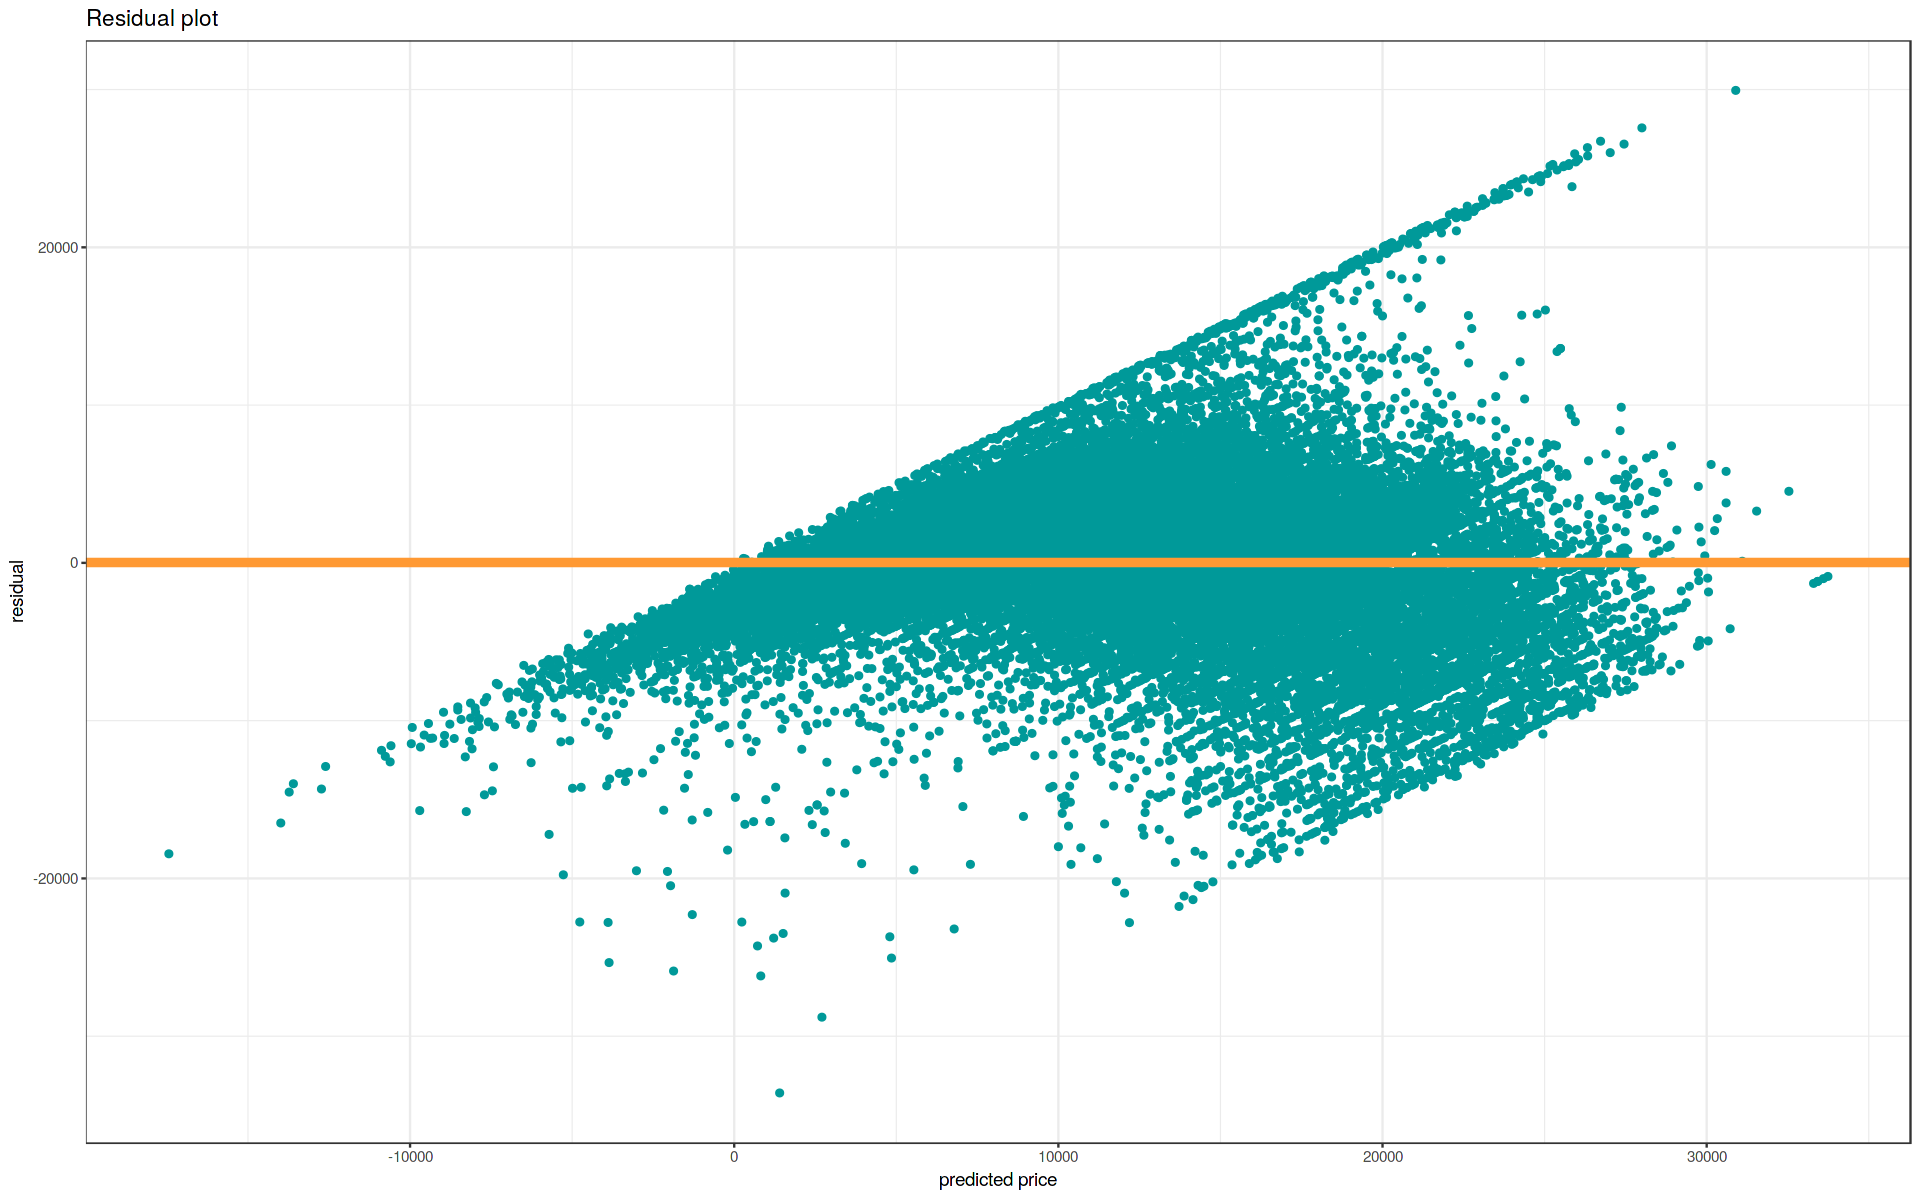

In [53]:
predictions = predict(model,test_set[!names(test_set) %in% c('price')])
residual = predictions - test_set$price

ggplot() + 
geom_point(aes(x= predictions, y= residual), color='#009999') + 
geom_abline(slope = 0, intercept = 0, color='#ff9933', lwd = 2) +
xlab('predicted price') +
ylab('residual') +
ggtitle('Residual plot')

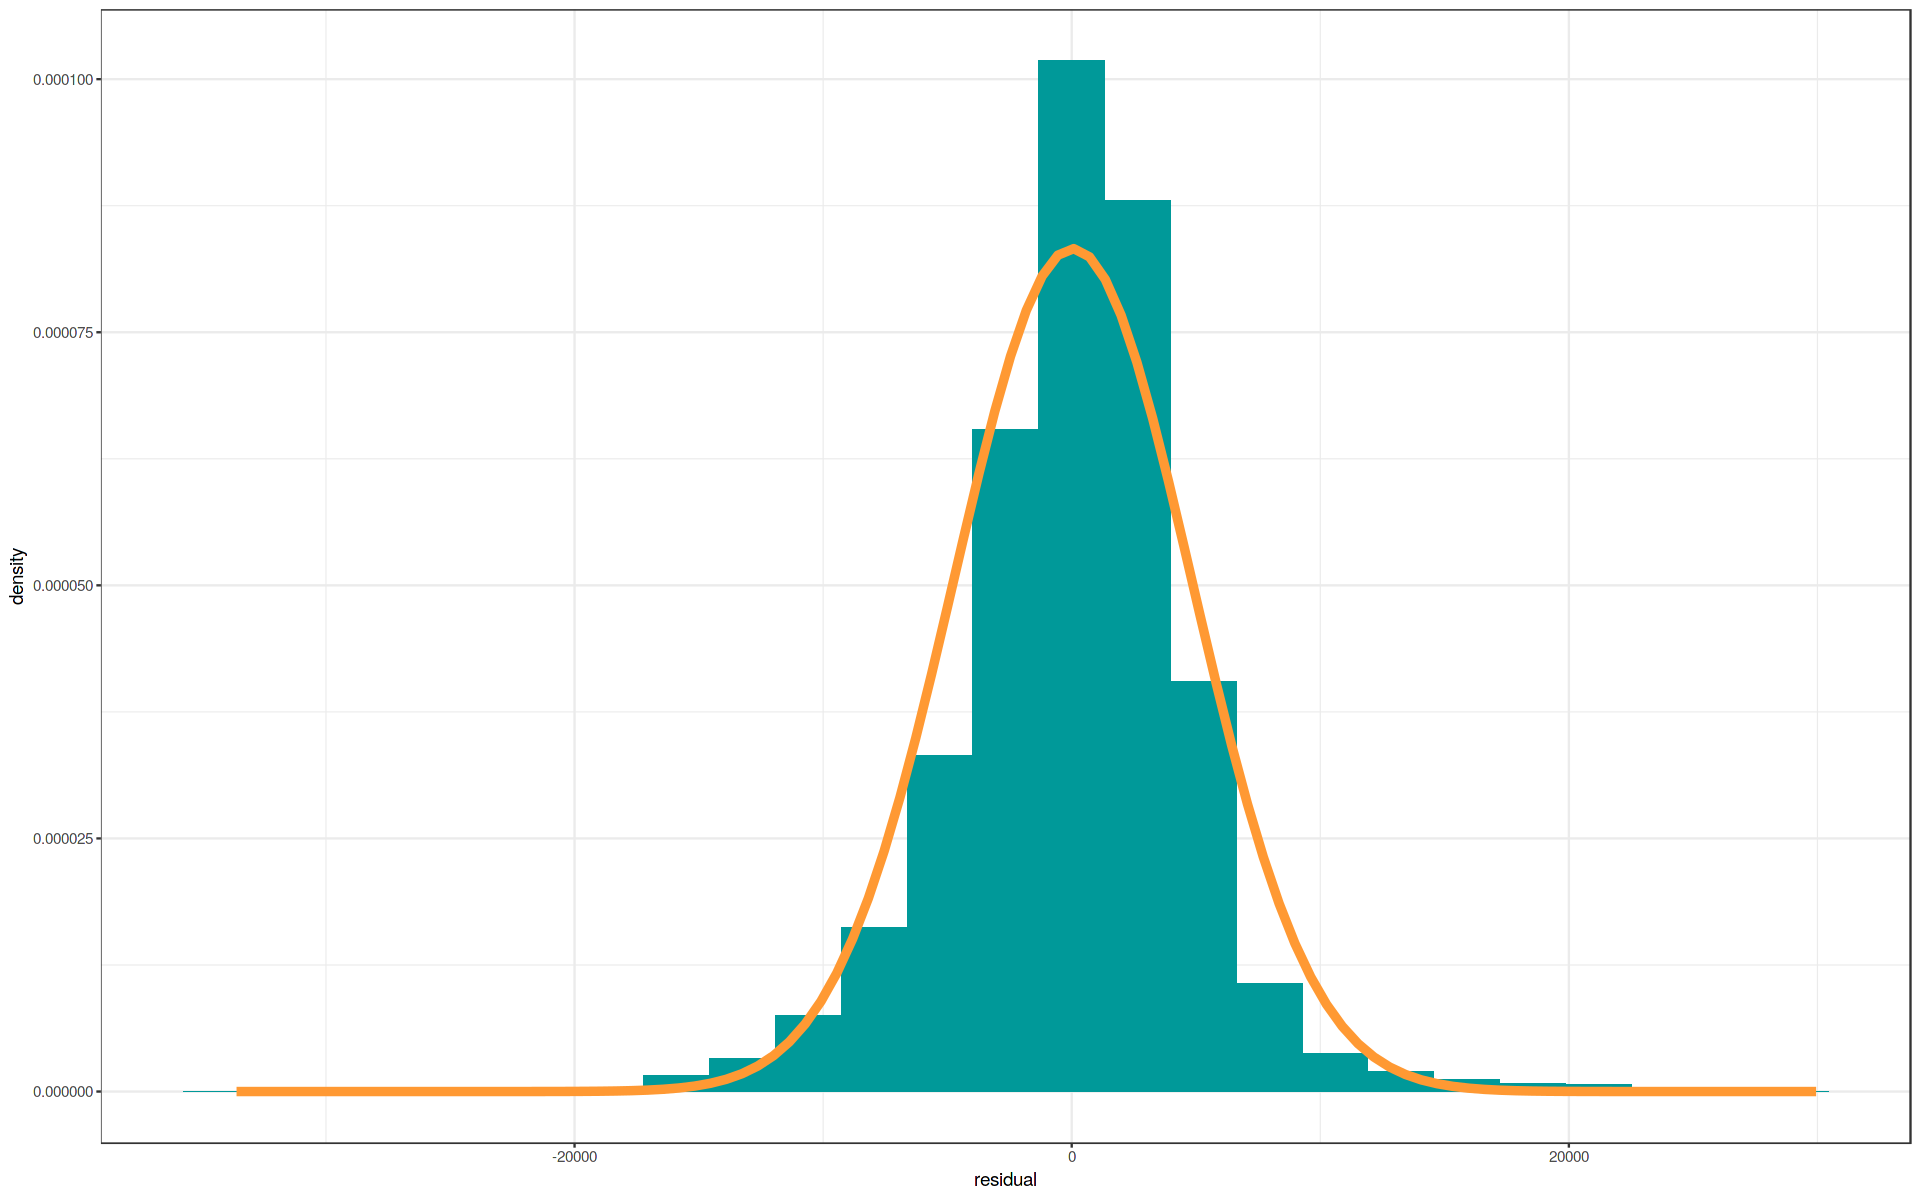

In [54]:
res_data = as.data.frame(residual)
m = mean(res_data$residual)
s = sd(res_data$residual)

ggplot(data = res_data, aes(x = residual)) + 
geom_histogram(aes(y = ..density..), fill='#009999', bins=25) + 
stat_function(fun = dnorm, args = list(mean= m,sd=s), color= '#ff9933', size=2)

A residual plot shows the variance of error the plot makes in the predictions. The variance seems well distributed at the 0 point. This shows that the residuals are homoskedastic. Which is a favourable condition.<br>

In conclusion we can say, the following characteristics are good predictors of the price of a car:-
* Year it is sold in
* Location of the seller
* Fuel type of the car
* Body type of the car
* Wheel drive of the car
* Transmission of the car
* Status of the car

With these predictors, a good fit is seen with normally distributed residual error and a fair RMSE value.
